# TABLE OF CONTENTS

1. [Basic Imports](#basic_imports) 
2. [Data Understanding](#data_understanding)
3. [Exploratory Data Analysis (EDA)](#eda)
    1. [Average Balance per Account](#eda1)
    2. [Monthly Balance & Transaction Behaviour](#eda2)
    3. [Monthly Debit & Credit Statistics](#eda3)
    4. [Credit Card Limit, Active Cards & Delinquencies](#eda4)
4. [Data Preparation](#dataprep)
    1. [Bank Account Aggregation](#dataprep1)
    2. [Bank Transaction Aggregation](#dataprep2)
    3. [Credit Card Aggregation](#dataprep3)
    4. [Joining All Bank Data](#dataprep4)
    5. [Overview of Aggregated Data](#dataprep5)
5. [Data Modelling & Evaluation](#modelling)
    1. [Train/Test Split](#modelling1)
    2. [Population Stability Index (PSI)](#modelling1a)
    2. [Feature Selection (IV & VIF)](#modelling2)
    3. [Model Development - Experiment0 - Best Algorithm](#modelling3)
    4. [Model Development - Experiment1 - Adding Class Weights](#modelling4)
    5. [Model Development - Experiment2 - Adding Domain Features](#modelling5)
    6. [Model Development - Experiment3 - Using WOE Binnings](#modelling6)
    7. [Model Development - Experiment4 - Optuna Hyperparameter Tuning](#modelling7)
    8. [Model Explainability & Probability of Default (PD)](#modelling8)

# IMPORT LIBRARIES, MODULES & DATA <a name='basic_imports'></a>

In [1]:
# importing modules
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import scorecardpy as sc
import optuna
import shap
from tqdm import tqdm

from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from scipy.stats import skew, kurtosis, shapiro, mannwhitneyu

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

# format output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

C:\Users\Bhaskara\Anaconda3\envs\myenv_update\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# importing percentile helper functions
def percentile_(n):
    def percentile(grp):
        return grp.quantile(n / 100)
    percentile.__name__ = f'{n}%'
    return percentile

# importing describer helper functions
def describe_(data):
    listItem = []
    for col in data.columns:
        listItem.append([col, data[col].dtype, data[col].notna().sum(), data[col].isna().sum(),
                        round((data[col].isna().sum()/len(data[col])) * 100,2),
                        data[col].nunique(), list(data[col].drop_duplicates().sample(1).values)]);
    dfDesc = pd.DataFrame(columns=['Data Features', 'Data Type', 'Not-Null Count', 'Null Count', 'Null %', 
                                   'N-Unique', 'Unique Sample'],
                         data=listItem)
    return dfDesc

# importing group gini helper function
def get_gini(grp, column_response, column_score):
    return 2 * metrics.roc_auc_score(grp[column_response], grp[column_score]) - 1

# importing data normality describer helper functions (for numerical features only)
def statistics_(data, target):
    listItem = []
    for col in data.columns:
        if np.issubdtype(data[col].dtype, np.number):  
            # skewness & kurtosis
            col_skewness = skew(data[col].dropna())
            col_kurtosis = kurtosis(data[col].dropna())
            # normality
            _, p_value_normality = shapiro(data[col].dropna())
            normality = 'Normal Distribution' if p_value_normality > 0.05 else 'Non-Normal Distribution'
            # mannwhitneyu
            group1 = data[data[target] == data[target].unique()[0]][col].dropna()
            group2 = data[data[target] == data[target].unique()[1]][col].dropna()
            if len(group1) > 0 and len(group2) > 0:
                _, p_value_mannwhitneyu = mannwhitneyu(group1, group2)
            else:
                p_value_mannwhitneyu = np.nan # not enough to analyze
            mannwhitney = 'Insignificant Difference' if p_value_mannwhitneyu > 0.05 else 'Significant Difference'
                
        else:
            col_skewness = col_kurtosis = np.nan
            normality = np.nan
            p_value_normality
            mannwhitney = np.nan
            p_value_mannwhitneyu = np.nan

        listItem.append([col, col_skewness, col_kurtosis, 
                         normality, mannwhitney, p_value_mannwhitneyu])
        
    dfDesc = pd.DataFrame(columns=['Data Features','Skewness','Kurtosis',
                                   'Normality (Shapiro-Wilk)',
                                  'Mann-Whitney U', 'p-value'], data=listItem)
    
    return dfDesc

# importing psi table functions
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)


def generate_psi_tables(df1, df2, bucket_type='quantiles', buckets=5):
    df_psi = pd.DataFrame()
    
    for i in df1.columns:
        psi_value = calculate_psi(df1[i], df2[i], buckettype=bucket_type, buckets=buckets)
        psi_data = {'feature': i,
                    'PSI': psi_value}
        
        df_psi = df_psi.append(psi_data, ignore_index=True)
        
    return df_psi

In [3]:
# importing data
df1 = pd.read_csv('bank_account.csv')
df2 = pd.read_csv('bank_transaction.csv')
df3 = pd.read_csv('credit_card.csv')

# data contingency
account_df = df1.copy(deep=True)
trx_df = df2.copy(deep=True)
cc_df = df3.copy(deep=True)

# DATA UNDERSTANDING<a name='data_understanding'></a>

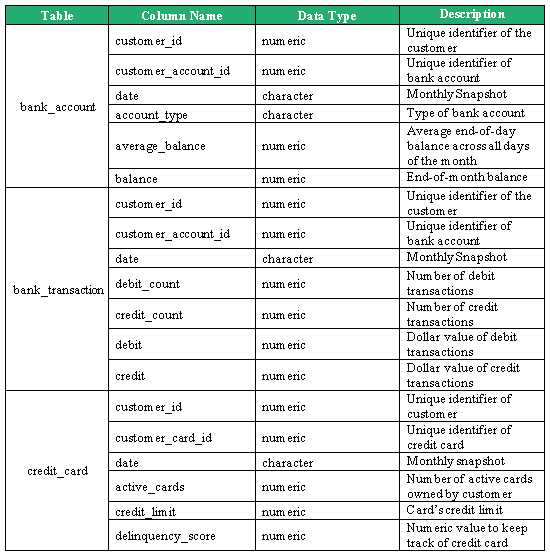

In [4]:
# getting the initial overview of bank accounts data
display(account_df.shape)
display(account_df.head())
display(describe_(account_df))
account_df.describe(include='all')

(1086524, 6)

,customer_id,customer_account_id,date,account_type,average_balance,balance
0,1,11718,2019-01-31,SAVING,649779.00,1305196.00
1,2,24834,2019-01-31,SAVING,18296187.00,23635664.00
2,2,25863,2019-01-31,SAVING,44436421.00,37980503.00
3,2,26200,2019-01-31,DEPOSITO,2600465.00,2600465.00
4,2,32082,2019-01-31,CHECKING,13352938.00,29816405.00


,Data Features,Data Type,Not-Null Count,Null Count,Null %,N-Unique,Unique Sample
0,customer_id,int64,1086524,0,0.00,37969,[15132]
1,customer_account_id,int64,1086524,0,0.00,100091,[97901]
2,date,object,1086524,0,0.00,12,[2019-12-31]
3,account_type,object,1086524,0,0.00,3,[SAVING]
4,average_balance,float64,1086524,0,0.00,912323,[1308314.0]
5,balance,float64,1086524,0,0.00,880397,[1836401.0]


,customer_id,customer_account_id,date,account_type,average_balance,balance
count,1086524.00,1086524.00,1086524,1086524,1086524.00,1086524.00
unique,NaN,NaN,12,3,NaN,NaN
top,NaN,NaN,2019-09-30,SAVING,NaN,NaN
freq,NaN,NaN,91274,886348,NaN,NaN
mean,17645.09,46190.33,NaN,NaN,57291413.38,57493652.80
std,10599.43,27136.47,NaN,NaN,280611705.59,286709199.81
min,1.00,1.00,NaN,NaN,0.00,0.00
25%,8400.00,22795.00,NaN,NaN,634886.25,375723.75
50%,17036.00,45669.00,NaN,NaN,4673620.50,4149719.00
75%,26318.00,68996.00,NaN,NaN,28149863.25,27632661.00


In [5]:
# getting the initial overview of bank trx data
display(trx_df.shape)
display(trx_df.head())
display(describe_(trx_df))
trx_df.describe(include='all')

(1038836, 7)

,customer_id,customer_account_id,date,debit_count,credit_count,debit,credit
0,1,11718,2019-01-31,6,3,4587588.00,4890076.00
1,2,24834,2019-01-31,4,2,8534412.00,16129689.00
2,2,25863,2019-01-31,2,1,36256211.00,14386938.00
3,2,26200,2019-01-31,1,1,2530.00,12650.00
4,2,32082,2019-01-31,1,1,5271.00,22139863.00


,Data Features,Data Type,Not-Null Count,Null Count,Null %,N-Unique,Unique Sample
0,customer_id,int64,1038836,0,0.00,37969,[32644]
1,customer_account_id,int64,1038836,0,0.00,100091,[70773]
2,date,object,1038836,0,0.00,12,[2019-03-31]
3,debit_count,int64,1038836,0,0.00,547,[413]
4,credit_count,int64,1038836,0,0.00,751,[242]
5,debit,float64,1038836,0,0.00,799617,[5010015.0]
6,credit,float64,1038836,0,0.00,830285,[6106616.0]


,customer_id,customer_account_id,date,debit_count,credit_count,debit,credit
count,1038836.00,1038836.00,1038836,1038836.00,1038836.00,1038836.00,1038836.00
unique,NaN,NaN,12,NaN,NaN,NaN,NaN
top,NaN,NaN,2019-07-31,NaN,NaN,NaN,NaN
freq,NaN,NaN,87252,NaN,NaN,NaN,NaN
mean,17660.93,45413.51,NaN,13.54,7.87,99580165.28,99767173.75
std,10604.17,27160.68,NaN,32.79,30.28,2020147134.26,2018971946.98
min,1.00,1.00,NaN,1.00,1.00,0.00,0.00
25%,8416.00,21933.75,NaN,2.00,2.00,95509.00,226868.75
50%,17073.00,44088.00,NaN,5.00,3.00,5853196.00,5558787.50
75%,26342.00,68118.00,NaN,16.00,7.00,37494296.25,37263859.50


In [6]:
# getting the initial overview of cc=redit card data
display(cc_df.shape)
display(cc_df.head())
display(describe_(cc_df))
cc_df.describe(include='all')

(467715, 6)

,customer_id,customer_card_id,date,active_cards,credit_limit,delinquency_score
0,1,12381,31-01-19,1,2286732,1
1,2,2946,31-01-19,3,36064900,1
2,3,22856,31-01-19,1,5417291,0
3,4,16254,31-01-19,1,1076724,1
4,5,38782,31-01-19,1,33294200,1


,Data Features,Data Type,Not-Null Count,Null Count,Null %,N-Unique,Unique Sample
0,customer_id,int64,467715,0,0.00,37969,[33189]
1,customer_card_id,int64,467715,0,0.00,39025,[8265]
2,date,object,467715,0,0.00,12,[30-04-19]
3,active_cards,int64,467715,0,0.00,11,[2]
4,credit_limit,int64,467715,0,0.00,44066,[7854896]
5,delinquency_score,int64,467715,0,0.00,11,[5]


,customer_id,customer_card_id,date,active_cards,credit_limit,delinquency_score
count,467715.00,467715.00,467715,467715.00,467715.00,467715.00
unique,NaN,NaN,12,NaN,NaN,NaN
top,NaN,NaN,31-12-19,NaN,NaN,NaN
freq,NaN,NaN,39025,NaN,NaN,NaN
mean,18940.70,19488.64,NaN,0.89,16853256.16,0.90
std,10948.63,11251.52,NaN,0.84,27089852.37,0.68
min,1.00,1.00,NaN,0.00,0.00,-3.00
25%,9446.00,9745.00,NaN,0.00,2894984.00,1.00
50%,18904.00,19489.00,NaN,1.00,7444882.00,1.00
75%,28404.50,29233.00,NaN,1.00,20170686.00,1.00


In [7]:
# checking the total unique customer IDs in each of the data
print(f"total unique customer ID in bank accounts data    : {account_df.customer_id.nunique()}")
print(f"total unique customer ID in bank transaction data : {trx_df.customer_id.nunique()}")
print(f"total unique customer ID in credit card data      : {cc_df.customer_id.nunique()}")

total unique customer ID in bank accounts data    : 37969
total unique customer ID in bank transaction data : 37969
total unique customer ID in credit card data      : 37969


In [8]:
# standardizing the date formats across data (2019-01-31 & 31-01-19)
account_df['date'] = pd.to_datetime(account_df['date'])
trx_df['date'] = pd.to_datetime(trx_df['date'])
cc_df['date'] = pd.to_datetime(cc_df['date'])

# checking the data date spread for each of the data
print(f"bank accounts data min & max date     : {account_df['date'].min()} & {account_df['date'].max()}")
print(f"bank transactions data min & max date : {trx_df['date'].min()} & {trx_df['date'].max()}")
print(f"credit card data min & max date       : {cc_df['date'].min()} & {cc_df['date'].max()}")

bank accounts data min & max date     : 2019-01-31 00:00:00 & 2019-12-31 00:00:00
bank transactions data min & max date : 2019-01-31 00:00:00 & 2019-12-31 00:00:00
credit card data min & max date       : 2019-01-31 00:00:00 & 2019-12-31 00:00:00


In [9]:
# creating month column from date for each data
account_df['month'] = account_df['date'].dt.month
trx_df['month'] = trx_df['date'].dt.month
cc_df['month'] = cc_df['date'].dt.month

# knowing the unique months that exists within each customers in each data
check_months1 = account_df.groupby(['customer_id'])['month'].nunique().to_frame('nunique_months').reset_index()
check_months2 = trx_df.groupby(['customer_id'])['month'].nunique().to_frame('nunique_months').reset_index()
check_months3 = cc_df.groupby(['customer_id'])['month'].nunique().to_frame('nunique_months').reset_index()

# checking if there are customers that have < 12 nunique months
print(f"bank accounts customer IDs that has below 12 months     : {len(check_months1[check_months1.nunique_months<12])} customers")
print(f"bank transactions customer IDs that has below 12 months : {len(check_months2[check_months2.nunique_months<12])} customers")
print(f"credit card customer IDs that has below 12 months       : {len(check_months3[check_months3.nunique_months<12])} customers")

bank accounts customer IDs that has below 12 months     : 0 customers
bank transactions customer IDs that has below 12 months : 0 customers
credit card customer IDs that has below 12 months       : 0 customers


In [10]:
# showing the nunqiue months data spread across data (min-max are all 12 and 0 std.deviation)
display("Bank Accounts Data",check_months1.nunique_months.describe().to_frame())
display("Bank Transactions Data",check_months2.nunique_months.describe().to_frame())
display("Credit Card Data", check_months3.nunique_months.describe().to_frame())

'Bank Accounts Data'

,nunique_months
count,37969.00
mean,12.00
std,0.00
min,12.00
25%,12.00
50%,12.00
75%,12.00
max,12.00


'Bank Transactions Data'

,nunique_months
count,37969.00
mean,12.00
std,0.00
min,12.00
25%,12.00
50%,12.00
75%,12.00
max,12.00


'Credit Card Data'

,nunique_months
count,37969.00
mean,12.00
std,0.00
min,12.00
25%,12.00
50%,12.00
75%,12.00
max,12.00


### Things to highlight:
- It is good to know that there are no null values at all in each of the data source. In other words, there would be no need for an initial null handling (that would result in an introduced bias). There seems to be an indication for the existence of outliers, but its handling would be done later in the analysis.
- There are around 37,9k distinct customers with their data spread in the month of 2019. Every customer seems to have at least 1 bank account type & its report is equally recorded at the end of each month (12 months).

# EXPLORATORY DATA ANALYSIS (EDA) <a name='eda'></a>

## A) Average Balance per Account <a name='eda1'></a>

In [11]:
# checking the average balance descriptive analytics per account type, across the months
account_df.groupby(['account_type']).agg({'average_balance':['count','mean','std','min',percentile_(10),
                                                             percentile_(50),percentile_(75),percentile_(90),'max']})

average_balance                                            \
                       count         mean          std  min        10%   
account_type                                                             
CHECKING               83560  72073008.22 387024878.24 0.00       0.00   
DEPOSITO              116616 174145175.96 563692029.55 0.00 2739724.00   
SAVING                886348  40523542.92 196218163.35 0.00   71057.60   

                                                                   
                     50%          75%          90%            max  
account_type                                                       
CHECKING      2269637.50  23389731.75 127801310.10 44448702627.00  
DEPOSITO     50143312.00 151955438.75 387702312.00 20268932956.00  
SAVING        3596320.50  19286960.25  80138917.20 25861534329.00

In [12]:
# checking the account type proportions
display(
    pd.concat([
        account_df['account_type'].value_counts().to_frame('count'),
        account_df['account_type'].value_counts(normalize=True).to_frame('proportion'),
    ],axis=1)
)

,count,proportion
SAVING,886348,0.82
DEPOSITO,116616,0.11
CHECKING,83560,0.08


### Things to highlight:
- DEPOSITO account have the highest average balance across the years with the average of Rp174,1 million and accounts only around 11% of all accounts count. Not only that, it also has the highest median average balance value across account types with value of Rp50,1 million. It is also worth noting that, 90% of the DEPOSITO accounts has at least the average balance of Rp2.7 million & most of them has the average balance value below Rp387,7 million across the years.
- Most of the accounts are SAVINGS account (82%) with the lowest average balance from all accounts across the years, having the value of Rp40,5 million. As it can also be seen from the data, 90% of the SAVING accounts has the average balance below Rp80,1 million.
- In terms of coefficient of variation (CV), DEPOSITO account's average balance has the lowest CV of 3.2. Meaning that although theres already a large amount of variability in the data (CV>1), it is still comparatively lower than the other two account types. CHECKING account has the highest CV of 5.3, showing that it's average balance value has the most data variability & dispersion

## B) Monthly Balance & Transaction Behaviour <a name=eda2></a>

In [13]:
# showcasing that there are customers that has more than 1 account type 
check_types = account_df.groupby('customer_id')['account_type'].nunique().to_frame('nunique_account_types').reset_index()
display(check_types[check_types.customer_id.isin([2,7575,7576,7577,7578])])
account_df[account_df.customer_id==7575].sort_values(['month','account_type']).head(10)

,customer_id,nunique_account_types
1,2,3
7574,7575,3
7575,7576,1
7576,7577,1
7577,7578,1


,customer_id,customer_account_id,date,account_type,average_balance,balance,month
19623,7575,29877,2019-01-31,CHECKING,0.00,2665365797.00,1
19624,7575,53652,2019-01-31,DEPOSITO,145588201.00,145588201.00,1
19625,7575,62962,2019-01-31,DEPOSITO,218382301.00,218382301.00,1
19622,7575,5236,2019-01-31,SAVING,25345034.00,11243062.00,1
19626,7575,64184,2019-01-31,SAVING,11221075.00,13241828.00,1
108675,7575,29877,2019-02-28,CHECKING,1571797307.00,1400729438.00,2
108676,7575,53652,2019-02-28,DEPOSITO,145588201.00,145588201.00,2
108677,7575,62962,2019-02-28,DEPOSITO,218382301.00,218382301.00,2
108674,7575,5236,2019-02-28,SAVING,52015700.00,93628223.00,2
108678,7575,64184,2019-02-28,SAVING,3269625.00,8830808.00,2


In [14]:
# differentiating between account types
checking_df = account_df[account_df.account_type=='CHECKING']
deposito_df = account_df[account_df.account_type=='DEPOSITO']
saving_df = account_df[account_df.account_type=='SAVING']

In [15]:
# creating the aggregate of all account types balance grouped by each customer
all_agg_df = account_df\
                .groupby(['customer_id','month'])['balance'].sum()\
                .reset_index('month')\
                .sort_values(['customer_id','month'])
all_agg_df['previous_balance'] = all_agg_df['balance'].shift(1)
all_agg_df['monthly_trx'] = all_agg_df['balance'] - all_agg_df['previous_balance']
all_agg_df.loc[all_agg_df.month==1, ['previous_balance','monthly_trx']] = np.nan
print(f"\n ######## ALL ACCOUNT TYPE ########")
display(all_agg_df.head(13))

# showcasing the avg monthly trx & its balance volatility/stability
all_agg_df_bal = all_agg_df.groupby('customer_id')[['balance']].mean().rename(columns={'balance':'avg_monthly_balance'})
all_agg_df_mean = all_agg_df.groupby('customer_id')[['monthly_trx']].mean().rename(columns={'monthly_trx':'avg_monthly_trx'})
all_agg_df_std = all_agg_df.groupby('customer_id')[['monthly_trx']].std().rename(columns={'monthly_trx':'std_monthly_trx'})
all_agg_df_ = pd.concat([all_agg_df_bal, all_agg_df_mean, all_agg_df_std],axis=1)
display(all_agg_df_.sample(5))

# showcasing the avg monthly trx overall descriptive analytics
all_agg_df_.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])



 ######## ALL ACCOUNT TYPE ########


,month,balance,previous_balance,monthly_trx
customer_id,,,,
1,1,1305196.00,NaN,NaN
1,2,1411025.00,1305196.00,105829.00
1,3,442221.00,1411025.00,-968804.00
1,4,587654.00,442221.00,145433.00
1,5,294543.00,587654.00,-293111.00
1,6,983297.00,294543.00,688754.00
1,7,516598.00,983297.00,-466699.00
1,8,701291.00,516598.00,184693.00
1,9,487427.00,701291.00,-213864.00


,avg_monthly_balance,avg_monthly_trx,std_monthly_trx
customer_id,,,
37771,756885.42,43379.55,1167343.14
32531,15289087.17,-454671.55,5280413.05
18296,18466962.75,2316341.55,7715370.24
30827,4571308.08,769038.82,8593741.08
24274,25828020.17,21461.27,34282623.66


,avg_monthly_balance,avg_monthly_trx,std_monthly_trx
count,37969.00,37969.00,37969.00
mean,137103588.05,496015.56,52749472.87
std,820795517.84,37328530.81,234756513.41
min,0.00,-2626947158.82,0.00
5%,252050.85,-11595555.87,274883.75
25%,3015003.17,-621561.64,2810477.37
50%,14103910.50,285.73,10434772.59
75%,69227094.92,806324.82,35119127.03
95%,568768944.08,13375333.09,205735281.66
max,95691342921.08,1516517833.45,20790923585.67


In [16]:
# creating the aggregate for each of the account types balance
agg_dfs = {}
for i in account_df['account_type'].str.lower().unique():
    print(f"\n ######## {i.upper()} ########")
    agg_df = account_df[account_df['account_type'] == i.upper()]\
                .groupby(['customer_id', 'month'])['balance'].sum()\
                .reset_index()\
                .sort_values(['customer_id', 'month'])
    agg_df['previous_balance'] = agg_df['balance'].shift(1)
    agg_df['monthly_trx'] = agg_df['balance'] - agg_df['previous_balance']
    agg_df.loc[agg_df['month'] == 1, ['previous_balance', 'monthly_trx']] = np.nan
    display(agg_df.head(13))

    # showcasing each customer's avg monthly trx & its descriptive analytics for each account types
    agg_df_bal = agg_df.groupby('customer_id')[['balance']].mean().rename(columns={'balance':'avg_monthly_balance'})
    agg_df_mean = agg_df.groupby('customer_id')[['monthly_trx']].mean().rename(columns={'monthly_trx':'avg_monthly_trx'})
    agg_df_std = agg_df.groupby('customer_id')[['monthly_trx']].std().rename(columns={'monthly_trx':'std_monthly_trx'})
    agg_df_ = pd.concat([agg_df_bal, agg_df_mean, agg_df_std],axis=1)
    display(agg_df_.sample(5))
    display(agg_df_.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
    agg_dfs[f"{i}_agg_df"] = agg_df_



 ######## SAVING ########


,customer_id,month,balance,previous_balance,monthly_trx
0,1,1,1305196.00,NaN,NaN
1,1,2,1411025.00,1305196.00,105829.00
2,1,3,442221.00,1411025.00,-968804.00
3,1,4,587654.00,442221.00,145433.00
4,1,5,294543.00,587654.00,-293111.00
5,1,6,983297.00,294543.00,688754.00
6,1,7,516598.00,983297.00,-466699.00
7,1,8,701291.00,516598.00,184693.00
8,1,9,487427.00,701291.00,-213864.00
9,1,10,759283.00,487427.00,271856.00


,avg_monthly_balance,avg_monthly_trx,std_monthly_trx
customer_id,,,
6081,2329093.25,138020.18,4138183.19
15761,653235897.50,-34814104.18,164288336.14
30058,21412588.92,5726823.55,27053511.36
11975,4821468.00,-723605.09,7323776.34
12219,12558430.17,-3205843.91,17295476.86


,avg_monthly_balance,avg_monthly_trx,std_monthly_trx
count,37643.00,37642.00,37640.00
mean,80173676.57,156351.68,43975711.90
std,300873068.56,24069633.30,195938018.42
min,0.00,-866719212.00,0.00
5%,229073.19,-9646573.26,240509.40
25%,2670718.08,-566157.00,2621097.95
50%,11811647.42,-106.91,9600327.00
75%,49658652.79,668817.98,31905605.50
95%,349909026.47,10256546.57,172647171.97
max,12876449401.58,1389943077.91,22990929844.56



 ######## DEPOSITO ########


,customer_id,month,balance,previous_balance,monthly_trx
0,2,1,3271007441.00,NaN,NaN
1,2,2,3287212279.00,3271007441.00,16204838.00
2,2,3,3311900687.00,3287212279.00,24688408.00
3,2,4,3301602978.00,3311900687.00,-10297709.00
4,2,5,3266503143.00,3301602978.00,-35099835.00
5,2,6,3293355607.00,3266503143.00,26852464.00
6,2,7,3227672072.00,3293355607.00,-65683535.00
7,2,8,3222385533.00,3227672072.00,-5286539.00
8,2,9,3237912632.00,3222385533.00,15527099.00
9,2,10,4873953111.00,3237912632.00,1636040479.00


,avg_monthly_balance,avg_monthly_trx,std_monthly_trx
customer_id,,,
10181,283834414.00,0.00,0.00
24943,14369034.00,-435115.50,1375956.03
13681,265843701.75,-1725276.45,8500099.81
4702,6224093.50,22929.73,1750.84
23799,14060223.00,0.00,0.00


,avg_monthly_balance,avg_monthly_trx,std_monthly_trx
count,5457.00,5386.00,5262.00
mean,338632863.67,-10176027.72,83962931.46
std,1684976262.18,283793475.71,511726824.82
min,0.00,-18499848580.50,0.00
5%,1780174.62,-73197443.15,0.00
25%,16023802.00,-1713327.85,2834.81
50%,78699916.88,0.00,2636541.71
75%,279466901.00,708506.30,38448073.00
95%,1104657654.47,38586155.17,314580569.16
max,85774103923.33,2307889718.00,26163823743.08



 ######## CHECKING ########


,customer_id,month,balance,previous_balance,monthly_trx
0,2,1,31385965.00,NaN,NaN
1,2,2,22023519.00,31385965.00,-9362446.00
2,2,3,15358768.00,22023519.00,-6664751.00
3,2,4,15539800.00,15358768.00,181032.00
4,2,5,22859179.00,15539800.00,7319379.00
5,2,6,3252247.00,22859179.00,-19606932.00
6,2,7,4199094.00,3252247.00,946847.00
7,2,8,4190137.00,4199094.00,-8957.00
8,2,9,4181165.00,4190137.00,-8972.00
9,2,10,4172207.00,4181165.00,-8958.00


,avg_monthly_balance,avg_monthly_trx,std_monthly_trx
customer_id,,,
25347,0.00,0.00,0.00
17613,7320621.17,-823381.27,12490358.01
34759,27.88,-31.86,84.29
7157,12011045.42,-17473.91,57.85
18811,17841264.75,-1734532.36,6909828.56


,avg_monthly_balance,avg_monthly_trx,std_monthly_trx
count,5633.00,5614.00,5578.00
mean,87533715.30,-981703.31,66158130.52
std,373702176.35,47108312.20,260733922.45
min,0.00,-2440772637.18,0.00
5%,0.00,-12566306.88,0.00
25%,316363.42,-322226.45,65875.88
50%,4019658.00,0.00,4504524.26
75%,33292099.50,88410.57,33185739.83
95%,380325702.95,8431052.94,291722251.58
max,9165713447.00,1526570136.73,5627345669.08


### Things to highlight:
- In ALL ACCOUNT TYPE (aggregated calculation across account types), there seems to be an overall positive trend for influx of money coming in & increasing our customer's money balance. This is seen through their aggregated average monthly transaction of customers across the account types is around positive Rp496k. On the other hand, the fact that the overall customer's average monthly balance of Rp137,1 million is followed by the average monthly transaction volatility of around Rp52,7 million (38.4% of overall average monthly balance) indicates a broader trend of significant balance fluctuation in our customer base.
- When we try to dig deeper into the account types, it can be seen that it's only SAVING account that has positive average monthly transaction of Rp156k although it has a large value of standard deviation indicating a large spread of data. The other two account types, DEPOSITO & CHECKING, have values of negative average monthly transaction. In other words, it's only the SAVING account that relatively has the general trend of more money coming-in than coming-out compared to the other account types. Even though thats the case, the SAVING account still has a relatively high level of average transaction volatility in relative to its average monthly balance, showing the general trend of fluctuative financial situation of our customers.

## C) Monthly Debit & Credit Statistics <a name=eda3></a>

In [17]:
# adding account type information on the debit/credit transaction data
trx_df_ = trx_df.merge(account_df[['customer_id','customer_account_id','date','account_type']], 
                       how='inner', on=['customer_id','customer_account_id','date'])
print("merged shape:",trx_df_.shape, "\noriginal shape:",trx_df.shape)
display(trx_df_.head())

merged shape: (1038836, 9) 
original shape: (1038836, 8)


,customer_id,customer_account_id,date,debit_count,credit_count,debit,credit,month,account_type
0,1,11718,2019-01-31,6,3,4587588.00,4890076.00,1,SAVING
1,2,24834,2019-01-31,4,2,8534412.00,16129689.00,1,SAVING
2,2,25863,2019-01-31,2,1,36256211.00,14386938.00,1,SAVING
3,2,26200,2019-01-31,1,1,2530.00,12650.00,1,DEPOSITO
4,2,32082,2019-01-31,1,1,5271.00,22139863.00,1,CHECKING


In [18]:
# creating the aggregate of all account types balance grouped by each customer
print(f"\n ######## ALL ACCOUNT TYPE ########")
all_trx_agg_df = trx_df_\
                    .groupby(['customer_id','month'])[['debit','credit','debit_count','credit_count']].sum()\
                    .reset_index('month')\
                    .sort_values(['customer_id','month'])
all_trx_agg_df.head(5)

# creating the overall avg monthly debit (money coming-out) & credit (money coming-in) transaction statistics
all_trx_agg_df_debit_amt_mean = all_trx_agg_df.groupby('customer_id')[['debit']].mean().rename(columns={'debit':'avg_monthly_debit_amt'})
all_trx_agg_df_credit_amt_mean = all_trx_agg_df.groupby('customer_id')[['credit']].mean().rename(columns={'credit':'avg_monthly_credit_amt'})
all_trx_agg_df_debit_count_mean = all_trx_agg_df.groupby('customer_id')[['debit_count']].mean().rename(columns={'debit_count':'avg_monthly_debit_count'})
all_trx_agg_df_credit_count_mean = all_trx_agg_df.groupby('customer_id')[['credit_count']].mean().rename(columns={'credit_count':'avg_monthly_credit_count'})
all_trx_agg_df_ = pd.concat([all_trx_agg_df_debit_amt_mean, 
                            all_trx_agg_df_credit_amt_mean, 
                            all_trx_agg_df_debit_count_mean,
                            all_trx_agg_df_credit_count_mean
                           ],axis=1)
display(all_trx_agg_df_.sample(5))

# showcasing the overall avg monthly debit (money coming-out) & credit (money coming-in) transaction statistics
all_trx_agg_df_.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])




 ######## ALL ACCOUNT TYPE ########


,avg_monthly_debit_amt,avg_monthly_credit_amt,avg_monthly_debit_count,avg_monthly_credit_count
customer_id,,,,
26787,580801435.67,582199231.33,53.17,48.67
14676,77069555.00,72640046.67,31.00,10.92
21294,367414784.75,560385259.83,22.83,10.58
8053,119396764.67,119349751.08,32.33,16.83
19060,1087709653.33,1079901907.17,156.00,33.83


,avg_monthly_debit_amt,avg_monthly_credit_amt,avg_monthly_debit_count,avg_monthly_credit_count
count,37969.00,37969.00,37969.00,37969.00
mean,227043686.02,227470067.05,30.87,17.94
std,3189074306.25,3186291908.99,47.87,49.98
min,38.50,0.00,1.00,1.00
5%,1359318.15,1333410.55,2.75,1.75
25%,11169585.08,11140807.50,8.83,4.17
50%,36683584.83,36824884.33,19.67,8.33
75%,117390943.00,118090698.00,38.58,17.50
95%,710636110.68,712879045.05,93.25,58.67
max,516426286816.33,515900902573.75,4932.50,3703.50


In [19]:
# creating the aggregate for each of the account types transactions
trx_agg_dfs = {}
for i in trx_df_['account_type'].str.lower().unique():
    print(f"\n ######## {i.upper()} ########")
    trx_agg_df = trx_df_[trx_df_['account_type'] == i.upper()]\
                        .groupby(['customer_id','month'])[['debit','credit','debit_count','credit_count']].sum()\
                        .reset_index('month')\
                        .sort_values(['customer_id','month'])
    display(trx_agg_df.head(5))

    # creating & showcasing the avg monthly debit (money coming-out) & credit (money coming-in) transaction statistics
    trx_agg_df_debit_amt_mean = trx_agg_df.groupby('customer_id')[['debit']].mean().rename(columns={'debit':'avg_monthly_debit_amt'})
    trx_agg_df_credit_amt_mean = trx_agg_df.groupby('customer_id')[['credit']].mean().rename(columns={'credit':'avg_monthly_credit_amt'})
    trx_agg_df_debit_count_mean = trx_agg_df.groupby('customer_id')[['debit_count']].mean().rename(columns={'debit_count':'avg_monthly_debit_count'})
    trx_agg_df_credit_count_mean = trx_agg_df.groupby('customer_id')[['credit_count']].mean().rename(columns={'credit_count':'avg_monthly_credit_count'})
    trx_agg_df_ = pd.concat([trx_agg_df_debit_amt_mean, 
                            trx_agg_df_credit_amt_mean, 
                            trx_agg_df_debit_count_mean,
                            trx_agg_df_credit_count_mean
                           ],axis=1)
    display(trx_agg_df_.head(5))
    display(trx_agg_df_.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))
    trx_agg_dfs[f"{i}_trx_agg_df"] = trx_agg_df_


 ######## SAVING ########


,month,debit,credit,debit_count,credit_count
customer_id,,,,,
1,1,4587588.00,4890076.00,6,3
1,2,2846841.00,2952670.00,6,2
1,3,3606222.00,2637418.00,5,2
1,4,4026064.00,4171498.00,7,3
1,5,4918141.00,4625029.00,6,3


,avg_monthly_debit_amt,avg_monthly_credit_amt,avg_monthly_debit_count,avg_monthly_credit_count
customer_id,,,,
1,3437795.67,3417101.50,5.25,2.58
2,238221453.08,130638438.25,9.75,8.83
3,24126293.17,24144022.00,33.08,8.00
4,18373889.83,18422954.17,6.42,4.75
5,283695155.67,307136168.33,42.67,11.75


,avg_monthly_debit_amt,avg_monthly_credit_amt,avg_monthly_debit_count,avg_monthly_credit_count
count,37643.00,37643.00,37643.00,37643.00
mean,152622360.07,152851098.28,28.69,16.00
std,857088667.76,856975042.00,45.83,47.37
min,0.00,0.00,1.00,1.00
5%,1099345.16,1078508.52,2.40,1.57
25%,10072224.67,10067091.92,7.92,3.75
50%,32846240.58,32811200.92,18.08,7.50
75%,100682145.62,100987898.75,36.00,15.58
95%,538843120.50,538451365.70,87.08,51.58
max,70798235436.75,70802550612.75,4918.08,3703.50



 ######## DEPOSITO ########


,month,debit,credit,debit_count,credit_count
customer_id,,,,,
2,1,61496.00,307494.00,3,3
2,2,57853.00,289216.00,3,3
2,3,87172.00,435895.00,4,4
2,4,59843.00,299166.00,3,3
2,5,56779.00,283909.00,3,3


,avg_monthly_debit_amt,avg_monthly_credit_amt,avg_monthly_debit_count,avg_monthly_credit_count
customer_id,,,,
2,134837568.75,134304643.25,3.50,3.50
10,36760.92,99637389.42,17.50,18.33
37,1239.58,6197.75,1.00,1.00
40,329671682.40,343038448.00,4.50,3.80
56,43151.75,215758.75,1.00,1.00


,avg_monthly_debit_amt,avg_monthly_credit_amt,avg_monthly_debit_count,avg_monthly_credit_count
count,5457.00,5457.00,5457.00,5457.00
mean,29934909.09,32229815.72,3.28,2.84
std,184417579.09,156246170.41,4.77,4.29
min,0.00,35.36,1.00,1.00
5%,3372.92,16219.73,1.00,1.00
25%,65303.50,192036.33,1.58,1.08
50%,748432.44,1612582.00,2.00,2.00
75%,9015954.00,12539335.75,3.50,3.00
95%,106234000.08,126108905.10,8.92,7.83
max,5821672749.00,4663007603.56,224.42,217.83



 ######## CHECKING ########


,month,debit,credit,debit_count,credit_count
customer_id,,,,,
2,1,9975.00,22139863.00,2,2
2,2,10151760.00,789315.00,3,2
2,3,6668822.00,4070.00,2,2
2,4,9977.00,191009.00,2,2
2,5,20253834.00,27573213.00,3,2


,avg_monthly_debit_amt,avg_monthly_credit_amt,avg_monthly_debit_count,avg_monthly_credit_count
customer_id,,,,
2,4730204.92,4958526.00,2.17,2.00
27,245275856.33,244525316.33,45.33,15.67
28,130064694.92,127715913.83,51.42,8.00
34,368457339.83,371210372.17,17.83,14.92
37,106134140.83,106134140.92,1.58,1.83


,avg_monthly_debit_amt,avg_monthly_credit_amt,avg_monthly_debit_count,avg_monthly_credit_count
count,5633.00,5633.00,5633.00,5633.00
mean,501823829.74,501282412.33,14.14,12.05
std,7851253690.46,7844321054.94,26.06,30.28
min,0.00,0.00,1.00,1.00
5%,4605.45,346.40,1.00,1.00
25%,3204822.00,3170630.17,2.00,1.75
50%,35516239.42,35459437.33,4.67,3.33
75%,188345638.33,189460116.25,14.17,10.00
95%,1383419596.92,1391891475.17,59.45,49.78
max,515956828905.25,515431977529.33,469.00,689.58


### Things to highlight:
- In ALL ACCOUNT TYPE debit-credit statistics, in line with the previous analysis, there seems to be an overall positive influx of money coming-in. It can be seen from the overall average & median of the whole customer's average monthly credit trx amount being higher than its average monthly debit trx amount counterpart with absolute difference around USD426,3k. In other words, there's more money coming-in than coming-out of the accounts. With that being said, the average monthly debit trx count is almost twice as much of its credit counterpart. Meaning that the our customers tends to do more debit transactions than credit ones, though with generally lesser amount in total.
- The only account type where our customers has lower average monthly credit trx amount (average money coming-in) is CHECKING account with its absolute amount difference around USD541,4k. This is to be expected since the nature of checking accounts in general are for daily usage/operations/transactions whereas savings & deposito account are more for saving purposes.

## D) Credit Card Limit, Active Cards & Delinquencies <a name=eda4></a>

In [20]:
# checking the individual customers samples that has cc card ownership more than 1
display(cc_df[cc_df.customer_id.isin([2,3,33,34,35])].head(5))
cc_df[cc_df.customer_id==35].sort_values(['customer_id','month'])

,customer_id,customer_card_id,date,active_cards,credit_limit,delinquency_score,month
1,2,2946,2019-01-31,3,36064900,1,1
2,3,22856,2019-01-31,1,5417291,0,1
32,33,4836,2019-01-31,1,52618907,1,1
33,34,6215,2019-01-31,1,120626995,1,1
34,35,12430,2019-01-31,6,27193558,1,1


,customer_id,customer_card_id,date,active_cards,credit_limit,delinquency_score,month
34,35,12430,2019-01-31,6,27193558,1,1
38950,35,12430,2019-02-28,2,27193558,1,2
77870,35,12430,2019-03-31,3,27193558,1,3
116804,35,12430,2019-04-30,2,27193558,1,4
155754,35,12430,2019-05-31,2,27193558,1,5
194721,35,12430,2019-06-30,2,27193558,1,6
233697,35,12430,2019-07-31,3,27193558,1,7
272685,35,12430,2019-08-31,2,27193558,1,8
311683,35,12430,2019-09-30,2,27193558,1,9
350687,35,12430,2019-10-31,2,27193558,1,10


In [21]:
# creating the monthly aggregation data by customer
check_card = cc_df.groupby(['customer_id','month']).agg({
                                                'customer_card_id':['nunique'], 
                                                'active_cards':['min','median','max'],
                                                'delinquency_score':['min','mean','max'],
                                                'credit_limit':['nunique','min','mean','max']
                                                })
check_card.columns = [f"{x[0]}_{x[1]}" for x in check_card.columns]

# creating the default definition based on the delinquency score
check_card['is_default'] = check_card['delinquency_score_max'].apply(lambda x: 1 if x >= 4 else 0)
display(check_card.describe())

,customer_card_id_nunique,active_cards_min,active_cards_median,active_cards_max,delinquency_score_min,delinquency_score_mean,delinquency_score_max,credit_limit_nunique,credit_limit_min,credit_limit_mean,credit_limit_max,is_default
count,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00
mean,1.03,0.88,0.90,0.91,0.90,0.90,0.91,1.02,16322016.19,16603759.21,16888123.80,0.01
std,0.16,0.83,0.83,0.84,0.68,0.67,0.68,0.15,25718630.43,26170538.77,27135142.12,0.09
min,1.00,0.00,0.00,0.00,-3.00,-3.00,-3.00,1.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,2848759.00,2876956.00,2881588.00,0.00
50%,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,7263113.00,7392420.00,7429266.00,0.00
75%,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,19613504.00,19988756.00,20292286.00,0.00
max,4.00,11.00,11.00,11.00,9.00,9.00,9.00,3.00,1061994715.00,1061994715.00,1061994715.00,1.00


<AxesSubplot:>

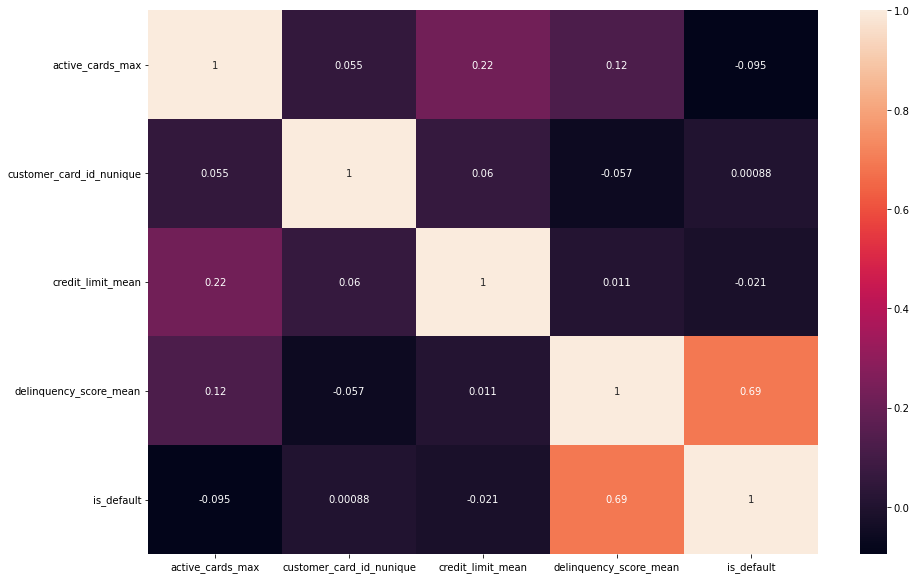

In [22]:
# showcasing pearson correlation for monthly aggregated customer data with our target default
plt.figure(figsize=(15,10))
sns.heatmap(check_card[['active_cards_max','customer_card_id_nunique',
                        'credit_limit_mean','delinquency_score_mean','is_default']]\
                .corr(method='pearson'),annot=True)

<AxesSubplot:>

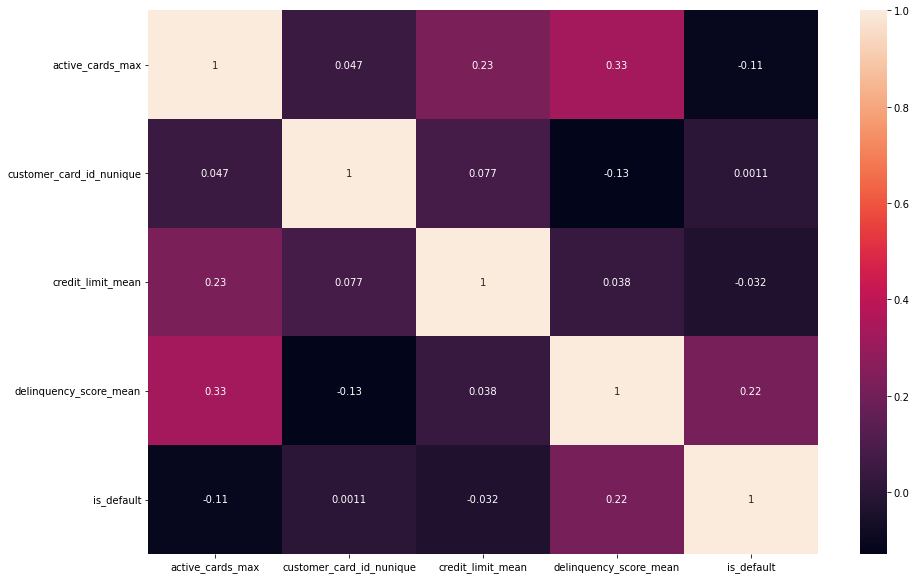

In [23]:
# showcasing spearman correlation for monthly aggregated customer data with our target default
plt.figure(figsize=(15,10))
sns.heatmap(check_card[['active_cards_max','customer_card_id_nunique',
                        'credit_limit_mean','delinquency_score_mean','is_default']]\
                .corr(method='spearman'),annot=True)

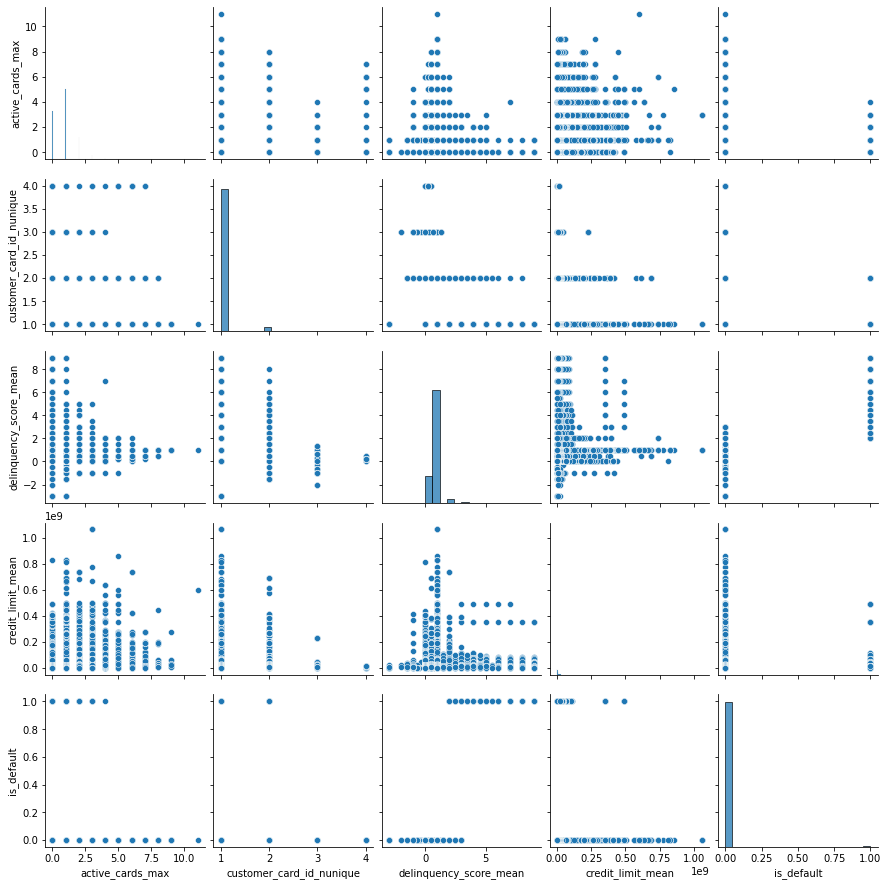

In [24]:
# draw pairplot relevant features
sns.pairplot(check_card[['active_cards_max','customer_card_id_nunique',
                         'delinquency_score_mean','credit_limit_mean','is_default']])

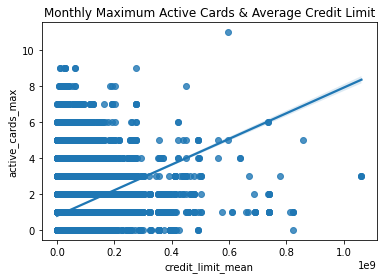

In [34]:
# draw regplot specifically for average credit limit & active cards maximum
plt.title('Monthly Maximum Active Cards & Average Credit Limit')
sns.regplot(x = "credit_limit_mean", 
            y = "active_cards_max", 
            data = check_card)
plt.show()

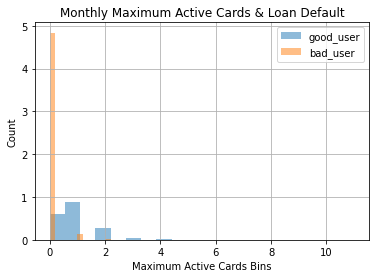

In [23]:
plt.title('Monthly Maximum Active Cards & Loan Default')
check_card[check_card['is_default']==0]['active_cards_max'].hist(bins = 20, alpha = 0.5, label = 'good_user', density = True)
check_card[check_card['is_default']==1]['active_cards_max'].hist(bins = 20, alpha = 0.5, label = 'bad_user', density = True)
plt.xlabel('Maximum Active Cards Bins')
plt.ylabel('Count')
plt.legend()
plt.show()

### Things to highlight:
- As it can be seen from the pearson correlation analysis, there seems to be some negative linear relationship, although it's relatively weak, between user default & their maximum active cards with correlation coefficient of 0,09. Futhermore, the spearman analysis between those features shows an even higher correlation coefficient of 0,11 which means that there's weak to moderate negative monotonic relationship between user default & their maximum active cards. In other words, the occurence of defaulting users (worse performing loans) is usually followed by the fact that the user has less maximum cards currently active (less active cards). Perhaps, the hypothesis is that with more active cards the user have, he/she is perceived to be more trustworthy in their capacity for repayment. At least, they have proved to be creditworthy to have those increased levels of active cards in the first place.
- It is also worth noting that there seems to be a moderately positive linear as well as monotonic relationship between maximum user active cards & their average credit limit with correlation coefficient around 0,22-0,23. To put it differently, the occurences where users have higher credit limits are usually followed by the fact that they also have more active cards/loans. It is more or less aligned with the previous hypothesis that posits users that have more active cards (in this case having more credit limits & creditworthiness) are usually safer, better users to begin with.


# DATA PREPARATION <a name='dataprep'></a>

Overall, these datasets are going to be prepared on a customer & date level; the primary key of each dataframe will be customer_id and date. We will implement further feature engineering & enrichment as needed.

## A) Bank Account Aggregation <a name='dataprep1'></a>

In [11]:
# previous original bank account data
account_df.head()

,customer_id,customer_account_id,date,account_type,average_balance,balance,month
0,1,11718,2019-01-31,SAVING,649779.00,1305196.00,1
1,2,24834,2019-01-31,SAVING,18296187.00,23635664.00,1
2,2,25863,2019-01-31,SAVING,44436421.00,37980503.00,1
3,2,26200,2019-01-31,DEPOSITO,2600465.00,2600465.00,1
4,2,32082,2019-01-31,CHECKING,13352938.00,29816405.00,1


In [17]:
%%time

# creating the all account aggregation
bank_acc_agg_df = account_df.sort_values(['customer_id','date'])\
                    .groupby(['customer_id','date','month'])\
                    .agg({
                            'customer_account_id':['nunique'],
                            'balance':['sum','mean'], 
                            'average_balance':['sum'],
                         })\
                    .reset_index('month')

bank_acc_agg_df.columns = [f"all_{x[0]}_{x[1]}" for x in bank_acc_agg_df.columns]
bank_acc_agg_df = bank_acc_agg_df.rename(columns={'all_month_':'month', 
                                                  'all_customer_account_id_nunique':'all_account_count'})


# creating the aggregate of all account types balance grouped by each customer & date
bank_acc_agg_df['all_previous_balance'] = bank_acc_agg_df['all_balance_sum'].shift(1)
bank_acc_agg_df['all_balance_change'] = bank_acc_agg_df['all_balance_sum'] - bank_acc_agg_df['all_previous_balance']
bank_acc_agg_df['all_balance_change_ratio'] = bank_acc_agg_df['all_balance_sum']/bank_acc_agg_df['all_previous_balance']
bank_acc_agg_df['all_balance_change%'] = round(bank_acc_agg_df['all_balance_change']/bank_acc_agg_df['all_previous_balance'],3)

# handling several data quirks (inf, nan first value, etc) & extra enrichment
bank_acc_agg_df.loc[(bank_acc_agg_df['all_balance_change_ratio']==np.inf) | (bank_acc_agg_df['all_balance_change%']==np.inf),
                     ['all_balance_change_ratio','all_balance_change%']] = 100
bank_acc_agg_df.loc[bank_acc_agg_df.month==1, ['all_previous_balance','all_balance_change','all_balance_change%','all_balance_change_ratio']] = np.nan
bank_acc_agg_df['all_balance_change%_3m'] = bank_acc_agg_df.groupby(['customer_id'])['all_balance_change%'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
bank_acc_agg_df['all_balance_change%_6m'] = bank_acc_agg_df.groupby(['customer_id'])['all_balance_change%'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
bank_acc_agg_df.head(5)

CPU times: total: 48 s
Wall time: 1min 22s


month  all_account_count  all_balance_sum  \
customer_id date                                                    
1           2019-01-31      1                  1       1305196.00   
            2019-02-28      2                  1       1411025.00   
            2019-03-31      3                  1        442221.00   
            2019-04-30      4                  1        587654.00   
            2019-05-31      5                  1        294543.00   

                        all_balance_mean  all_average_balance_sum  \
customer_id date                                                    
1           2019-01-31        1305196.00                649779.00   
            2019-02-28        1411025.00                463546.00   
            2019-03-31         442221.00                769761.00   
            2019-04-30         587654.00                403329.00   
            2019-05-31         294543.00                457605.00   

                        all_previous_balance  all_balance_change  \
customer_id date                                                   
1           2019-01-31                   NaN                 NaN   
            2019-02-28            1305196.00           105829.00   
            2019-03-31            1411025.00          -968804.00   
            2019-04-30             442221.00           145433.00   
            2019-05-31             587654.00          -293111.00   

                        all_balance_change_ratio  all_balance_change%  \
customer_id date                                                        
1           2019-01-31                       NaN                  NaN   
            2019-02-28                      1.08                 0.08   
            2019-03-31                      0.31                -0.69   
            2019-04-30                      1.33                 0.33   
            2019-05-31                      0.50                -0.50   

                        all_balance_change%_3m  all_balance_change%_6m  
customer_id date                                                        
1           2019-01-31                     NaN                     NaN  
            2019-02-28                    0.08                    0.08  
            2019-03-31                   -0.30                   -0.30  
            2019-04-30                   -0.09                   -0.09  
            2019-05-31                   -0.29                   -0.19

In [18]:
# checking agg data result
bank_acc_agg_df.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

,month,all_account_count,all_balance_sum,all_balance_mean,all_average_balance_sum,all_previous_balance,all_balance_change,all_balance_change_ratio,all_balance_change%,all_balance_change%_3m,all_balance_change%_6m
count,455628.00,455628.00,455628.00,455628.00,455628.00,417659.00,417659.00,417337.00,417337.00,417392.00,417408.00
mean,6.50,2.38,137103588.05,40893763.87,136621313.07,137049718.38,496015.56,7.30,6.30,6.15,5.99
std,3.45,2.45,850530005.41,150871378.94,848709903.64,852578201.94,232426995.49,540.77,540.77,301.61,225.26
min,1.00,1.00,0.00,0.00,0.00,0.00,-53304169457.00,0.00,-1.00,-1.00,-1.00
25%,3.75,1.00,1484351.75,956566.25,1906572.75,1487233.00,-3973009.00,0.63,-0.37,-0.05,0.00
50%,6.50,2.00,10522967.50,5986259.17,10919514.00,10516252.00,-11933.00,0.99,-0.01,0.13,0.25
75%,9.25,3.00,63543534.25,28904501.12,63323396.75,63383826.50,3487514.00,1.50,0.50,1.06,1.40
95%,12.00,6.00,570245688.45,179599861.52,567734625.10,569927760.20,61347148.80,9.74,8.74,11.71,12.94
99%,12.00,11.00,1936096183.16,516589822.89,1915472981.96,1930434298.68,294505473.00,65.23,64.23,61.93,61.03
max,12.00,235.00,107660939778.00,17218901148.00,110070372379.00,107660939778.00,29854052984.00,184554.00,184553.00,61517.02,46140.14


In [19]:
%%time

# creating the bank account aggregation by account type
bank_acc_aggs_dfs = {}
for i in account_df.account_type.str.lower().unique():
    print(f"\n ######## {i.upper()} ########")
    bank_acc_aggs = account_df[account_df.account_type==i.upper()]\
                        .sort_values(['customer_id','date'])\
                        .groupby(['customer_id','date','month'])\
                        .agg({
                                'customer_account_id':['nunique'],
                                'balance':['sum','mean'], 
                                'average_balance':['sum'],
                             })\
                        .reset_index('month')
    
    bank_acc_aggs.columns = [f"{i}_{x[0].lower()}_{x[1].lower()}" for x in bank_acc_aggs.columns]
    bank_acc_aggs = bank_acc_aggs.rename(columns={f'{i}_month_':'month',
                                                  f'{i}_customer_account_id_nunique': f'{i}_account_count'})

    # creating the aggregate of all account types balance grouped by each customer & date
    bank_acc_aggs[f'{i}_previous_balance'] = bank_acc_aggs[f'{i}_balance_sum'].shift(1)
    bank_acc_aggs[f'{i}_balance_change'] = bank_acc_aggs[f'{i}_balance_sum'] - bank_acc_aggs[f'{i}_previous_balance']
    bank_acc_aggs[f'{i}_balance_change_ratio'] = bank_acc_aggs[f'{i}_balance_sum']/bank_acc_aggs[f'{i}_previous_balance']
    bank_acc_aggs[f'{i}_balance_change%'] = round(bank_acc_aggs[f'{i}_balance_change']/bank_acc_aggs[f'{i}_previous_balance'],3)
    
    # handling several data quirks (inf, nan first value, etc) & extra enrichment
    bank_acc_aggs.loc[(bank_acc_aggs[f'{i}_balance_change_ratio']==np.inf) | 
                            (bank_acc_aggs[f'{i}_balance_change%']==np.inf),
                                        [f'{i}_balance_change_ratio',f'{i}_balance_change%']] = 100
    bank_acc_aggs.loc[bank_acc_aggs.month==1, [f'{i}_previous_balance',f'{i}_balance_change',f'{i}_balance_change%',f'{i}_balance_change_ratio']] = np.nan
    bank_acc_aggs[f'{i}_balance_change%_3m'] = bank_acc_aggs.groupby(['customer_id'])[f'{i}_balance_change%'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    bank_acc_aggs[f'{i}_balance_change%_6m'] = bank_acc_aggs.groupby(['customer_id'])[f'{i}_balance_change%'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
    bank_acc_aggs = bank_acc_aggs.drop('month',axis=1)
    bank_acc_aggs_dfs[f"{i}_bank_acc_agg_df"] = bank_acc_aggs
    display(bank_acc_aggs.head(5))
    display(bank_acc_aggs.describe(percentiles=[0.25,0.5,0.75,0.95,0.99]))


 ######## SAVING ########


saving_account_count  saving_balance_sum  \
customer_id date                                                   
1           2019-01-31                     1          1305196.00   
            2019-02-28                     1          1411025.00   
            2019-03-31                     1           442221.00   
            2019-04-30                     1           587654.00   
            2019-05-31                     1           294543.00   

                        saving_balance_mean  saving_average_balance_sum  \
customer_id date                                                          
1           2019-01-31           1305196.00                   649779.00   
            2019-02-28           1411025.00                   463546.00   
            2019-03-31            442221.00                   769761.00   
            2019-04-30            587654.00                   403329.00   
            2019-05-31            294543.00                   457605.00   

                        saving_previous_balance  saving_balance_change  \
customer_id date                                                         
1           2019-01-31                      NaN                    NaN   
            2019-02-28               1305196.00              105829.00   
            2019-03-31               1411025.00             -968804.00   
            2019-04-30                442221.00              145433.00   
            2019-05-31                587654.00             -293111.00   

                        saving_balance_change_ratio  saving_balance_change%  \
customer_id date                                                              
1           2019-01-31                          NaN                     NaN   
            2019-02-28                         1.08                    0.08   
            2019-03-31                         0.31                   -0.69   
            2019-04-30                         1.33                    0.33   
            2019-05-31                         0.50                   -0.50   

                        saving_balance_change%_3m  saving_balance_change%_6m  
customer_id date                                                              
1           2019-01-31                        NaN                        NaN  
            2019-02-28                       0.08                       0.08  
            2019-03-31                      -0.30                      -0.30  
            2019-04-30                      -0.09                      -0.09  
            2019-05-31                      -0.29                      -0.19

,saving_account_count,saving_balance_sum,saving_balance_mean,saving_average_balance_sum,saving_previous_balance,saving_balance_change,saving_balance_change_ratio,saving_balance_change%,saving_balance_change%_3m,saving_balance_change%_6m
count,451300.00,451300.00,451300.00,451300.00,413696.00,413696.00,413539.00,413539.00,413633.00,413670.00
mean,1.96,80229494.72,37385513.52,79587771.38,80198274.85,164120.04,7.49,6.49,6.30,6.16
std,1.83,341148678.84,152075815.50,325648369.36,339866919.35,193030696.35,544.21,544.21,303.37,227.22
min,1.00,0.00,0.00,0.00,0.00,-47919206816.00,0.00,-1.00,-1.00,-1.00
25%,1.00,1261484.50,860067.50,1686431.50,1264540.00,-3681951.25,0.60,-0.40,-0.06,0.01
50%,2.00,8523717.00,5280971.83,8929444.00,8519158.50,-11917.50,0.99,-0.01,0.17,0.30
75%,2.00,44662062.00,24416249.75,44758201.00,44603770.50,3173288.75,1.58,0.58,1.17,1.53
95%,5.00,355691388.50,163013725.35,353233701.65,355690731.00,53527327.75,10.39,9.39,12.34,13.59
99%,7.00,1128500992.48,489064211.77,1116828369.79,1134567237.85,246874396.20,68.26,67.26,65.18,64.01
max,223.00,52596793524.00,17218901148.00,28919690520.00,52596793524.00,48450602702.00,184554.00,184553.00,61517.02,46140.14



 ######## DEPOSITO ########


deposito_account_count  deposito_balance_sum  \
customer_id date                                                       
2           2019-01-31                       4         3271007441.00   
            2019-02-28                       4         3287212279.00   
            2019-03-31                       4         3311900687.00   
            2019-04-30                       4         3301602978.00   
            2019-05-31                       4         3266503143.00   

                        deposito_balance_mean  deposito_average_balance_sum  \
customer_id date                                                              
2           2019-01-31           817751860.25                 3292084810.00   
            2019-02-28           821803069.75                 3279075115.00   
            2019-03-31           827975171.75                 3310146366.00   
            2019-04-30           825400744.50                 3287476410.00   
            2019-05-31           816625785.75                 3285574165.00   

                        deposito_previous_balance  deposito_balance_change  \
customer_id date                                                             
2           2019-01-31                        NaN                      NaN   
            2019-02-28              3271007441.00              16204838.00   
            2019-03-31              3287212279.00              24688408.00   
            2019-04-30              3311900687.00             -10297709.00   
            2019-05-31              3301602978.00             -35099835.00   

                        deposito_balance_change_ratio  \
customer_id date                                        
2           2019-01-31                            NaN   
            2019-02-28                           1.00   
            2019-03-31                           1.01   
            2019-04-30                           1.00   
            2019-05-31                           0.99   

                        deposito_balance_change%  deposito_balance_change%_3m  \
customer_id date                                                                
2           2019-01-31                       NaN                          NaN   
            2019-02-28                      0.01                         0.01   
            2019-03-31                      0.01                         0.01   
            2019-04-30                     -0.00                         0.00   
            2019-05-31                     -0.01                        -0.00   

                        deposito_balance_change%_6m  
customer_id date                                     
2           2019-01-31                          NaN  
            2019-02-28                         0.01  
            2019-03-31                         0.01  
            2019-04-30                         0.00  
            2019-05-31                        -0.00

,deposito_account_count,deposito_balance_sum,deposito_balance_mean,deposito_average_balance_sum,deposito_previous_balance,deposito_balance_change,deposito_balance_change_ratio,deposito_balance_change%,deposito_balance_change%_3m,deposito_balance_change%_6m
count,55131.00,55131.00,55131.00,55131.00,50583.00,50583.00,50523.00,50523.00,50573.00,50573.00
mean,2.12,369944493.59,161882226.84,368361064.36,373972531.78,-2653084.84,2.08,1.09,1.49,1.68
std,2.75,1844643511.66,455013084.80,1840923682.12,1857697437.41,362977752.22,13.16,13.22,12.01,11.79
min,1.00,0.00,0.00,0.00,0.00,-37000465771.00,0.00,-1.00,-1.00,-1.00
25%,1.00,14878429.00,10921203.50,14606784.50,16323223.50,0.00,1.00,0.00,0.00,0.00
50%,1.00,84622353.00,49462976.00,84116761.00,87068682.00,0.00,1.00,0.00,0.00,0.00
75%,2.00,301268866.00,158014048.58,299827813.00,304186459.00,268399.00,1.00,0.00,0.00,0.00
95%,6.00,1162718373.50,568161840.00,1157930698.50,1166354241.00,10059360.60,1.01,0.01,0.54,2.48
99%,11.00,4370741944.70,1589656362.65,4361827460.80,4398734740.94,281313671.74,30.70,29.70,49.80,49.99
max,121.00,94315776526.00,17554647070.00,94315776526.00,94315776526.00,17554647070.00,1076.44,1075.43,956.74,956.74



 ######## CHECKING ########


checking_account_count  checking_balance_sum  \
customer_id date                                                       
2           2019-01-31                       2           31385965.00   
            2019-02-28                       2           22023519.00   
            2019-03-31                       2           15358768.00   
            2019-04-30                       2           15539800.00   
            2019-05-31                       2           22859179.00   

                        checking_balance_mean  checking_average_balance_sum  \
customer_id date                                                              
2           2019-01-31            15692982.50                   14927202.00   
            2019-02-28            11011759.50                   29179370.00   
            2019-03-31             7679384.00                   20734758.00   
            2019-04-30             7769900.00                   15402673.00   
            2019-05-31            11429589.50                   26063244.00   

                        checking_previous_balance  checking_balance_change  \
customer_id date                                                             
2           2019-01-31                        NaN                      NaN   
            2019-02-28                31385965.00              -9362446.00   
            2019-03-31                22023519.00              -6664751.00   
            2019-04-30                15358768.00                181032.00   
            2019-05-31                15539800.00               7319379.00   

                        checking_balance_change_ratio  \
customer_id date                                        
2           2019-01-31                            NaN   
            2019-02-28                           0.70   
            2019-03-31                           0.70   
            2019-04-30                           1.01   
            2019-05-31                           1.47   

                        checking_balance_change%  checking_balance_change%_3m  \
customer_id date                                                                
2           2019-01-31                       NaN                          NaN   
            2019-02-28                     -0.30                        -0.30   
            2019-03-31                     -0.30                        -0.30   
            2019-04-30                      0.01                        -0.20   
            2019-05-31                      0.47                         0.06   

                        checking_balance_change%_6m  
customer_id date                                     
2           2019-01-31                          NaN  
            2019-02-28                        -0.30  
            2019-03-31                        -0.30  
            2019-04-30                        -0.20  
            2019-05-31                        -0.03

,checking_account_count,checking_balance_sum,checking_balance_mean,checking_average_balance_sum,checking_previous_balance,checking_balance_change,checking_balance_change_ratio,checking_balance_change%,checking_balance_change%_3m,checking_balance_change%_6m
count,64506.00,64506.00,64506.00,64506.00,59211.00,59211.00,50395.00,50395.00,51439.00,52227.00
mean,1.30,90925693.29,59939325.66,93362176.65,92088705.12,-565832.86,7945.10,7944.12,8818.64,11210.20
std,0.81,460693808.17,292413263.00,483109280.74,464443101.99,263905260.09,1170437.77,1170437.77,704586.58,670058.51
min,1.00,0.00,0.00,0.00,0.00,-18596549718.00,0.00,-1.00,-1.00,-1.00
25%,1.00,54320.25,50187.50,135641.50,58939.00,-611917.00,0.67,-0.33,-0.03,-0.00
50%,1.00,1961850.50,1707442.50,3018151.00,2021453.00,0.00,1.00,0.00,0.06,0.21
75%,1.00,26223621.25,20856040.62,29990716.00,26584268.50,418419.50,1.35,0.35,1.36,2.47
95%,3.00,376699128.00,266451020.44,393241890.00,383570090.50,68325627.00,26.12,25.12,49.50,49.61
99%,5.00,1643836611.20,1040189190.15,1624570184.35,1677910940.40,418350617.40,154.66,153.66,280.38,438.09
max,18.00,27482458116.00,14812497820.00,45554074865.00,27482458116.00,12831024457.00,255034021.00,255034020.00,85011508.81,85011340.00


CPU times: total: 1min 22s
Wall time: 1min 43s


In [24]:
# sanity checking of unique customer ID count
saving_bank_acc_agg_df = bank_acc_aggs_dfs["saving_bank_acc_agg_df"]
deposito_bank_acc_agg_df = bank_acc_aggs_dfs["deposito_bank_acc_agg_df"]
checking_bank_acc_agg_df = bank_acc_aggs_dfs["checking_bank_acc_agg_df"]

print("all account original customers:",account_df.customer_id.nunique())
print("all account aggregated customers:",bank_acc_agg_df.reset_index('customer_id')\
                                          .customer_id.nunique())
print("saving account original customers:",saving_df.customer_id.nunique())
print("saving account aggregated customers:",saving_bank_acc_agg_df.reset_index('customer_id')\
                                              .customer_id.nunique())
print("deposito account original customers:",deposito_df.customer_id.nunique())
print("deposito account aggregated customers:",deposito_bank_acc_agg_df.reset_index('customer_id')\
                                              .customer_id.nunique())
print("checking account original customers:",checking_df.customer_id.nunique())
print("checking account aggregated customers:",checking_bank_acc_agg_df.reset_index('customer_id')\
                                              .customer_id.nunique())

all account original customers: 37969
all account aggregated customers: 37969
saving account original customers: 37643
saving account aggregated customers: 37643
deposito account original customers: 5457
deposito account aggregated customers: 5457
checking account original customers: 5633
checking account aggregated customers: 5633


In [25]:
# joining all the bank account data & sanity checking
bank_account_aggregated = bank_acc_agg_df.merge(saving_bank_acc_agg_df, how='left', left_index=True, right_index=True)\
                                        .merge(deposito_bank_acc_agg_df, how='left', left_index=True, right_index=True)\
                                        .merge(checking_bank_acc_agg_df, how='left', left_index=True, right_index=True)

display(bank_account_aggregated.shape)
display(bank_account_aggregated.reset_index('customer_id').customer_id.nunique() == account_df.customer_id.nunique())

(455628, 41)

True

In [26]:
# final data shape
bank_account_aggregated.head()

month  all_account_count  all_balance_sum  \
customer_id date                                                    
1           2019-01-31      1                  1       1305196.00   
            2019-02-28      2                  1       1411025.00   
            2019-03-31      3                  1        442221.00   
            2019-04-30      4                  1        587654.00   
            2019-05-31      5                  1        294543.00   

                        all_balance_mean  all_average_balance_sum  \
customer_id date                                                    
1           2019-01-31        1305196.00                649779.00   
            2019-02-28        1411025.00                463546.00   
            2019-03-31         442221.00                769761.00   
            2019-04-30         587654.00                403329.00   
            2019-05-31         294543.00                457605.00   

                        all_previous_balance  all_balance_change  \
customer_id date                                                   
1           2019-01-31                   NaN                 NaN   
            2019-02-28            1305196.00           105829.00   
            2019-03-31            1411025.00          -968804.00   
            2019-04-30             442221.00           145433.00   
            2019-05-31             587654.00          -293111.00   

                        all_balance_change_ratio  all_balance_change%  \
customer_id date                                                        
1           2019-01-31                       NaN                  NaN   
            2019-02-28                      1.08                 0.08   
            2019-03-31                      0.31                -0.69   
            2019-04-30                      1.33                 0.33   
            2019-05-31                      0.50                -0.50   

                        all_balance_change%_3m  all_balance_change%_6m  \
customer_id date                                                         
1           2019-01-31                     NaN                     NaN   
            2019-02-28                    0.08                    0.08   
            2019-03-31                   -0.30                   -0.30   
            2019-04-30                   -0.09                   -0.09   
            2019-05-31                   -0.29                   -0.19   

                        saving_account_count  saving_balance_sum  \
customer_id date                                                   
1           2019-01-31                  1.00          1305196.00   
            2019-02-28                  1.00          1411025.00   
            2019-03-31                  1.00           442221.00   
            2019-04-30                  1.00           587654.00   
            2019-05-31                  1.00           294543.00   

                        saving_balance_mean  saving_average_balance_sum  \
customer_id date                                                          
1           2019-01-31           1305196.00                   649779.00   
            2019-02-28           1411025.00                   463546.00   
            2019-03-31            442221.00                   769761.00   
            2019-04-30            587654.00                   403329.00   
            2019-05-31            294543.00                   457605.00   

                        saving_previous_balance  saving_balance_change  \
customer_id date                                                         
1           2019-01-31                      NaN                    NaN   
            2019-02-28               1305196.00              105829.00   
            2019-03-31               1411025.00             -968804.00   
            2019-04-30                442221.00              145433.00   
            2019-05-31                587654.00             -293111.00   

                        sa

## B) Bank Transaction Aggregation <a name='dataprep2'></a>

In [36]:
# previous original bank trx data
trx_df.head()

,customer_id,customer_account_id,date,debit_count,credit_count,debit,credit,month
0,1,11718,2019-01-31,6,3,4587588.00,4890076.00,1
1,2,24834,2019-01-31,4,2,8534412.00,16129689.00,1
2,2,25863,2019-01-31,2,1,36256211.00,14386938.00,1
3,2,26200,2019-01-31,1,1,2530.00,12650.00,1
4,2,32082,2019-01-31,1,1,5271.00,22139863.00,1


In [39]:
%%time

# create the aggregated transaction data
bank_trx_aggregated = trx_df.sort_values(['customer_id','date'])\
                            .groupby(['customer_id','date','month'])\
                            .agg({
                                    'debit_count':['sum','mean'], 
                                    'credit_count':['sum','mean'],
                                    'debit':['sum','mean','max'], 
                                    'credit':['sum','mean','max'],
                                 })\
                            .reset_index('month')
bank_trx_aggregated.columns = [f"all_{x[0]}_{x[1]}" for x in bank_trx_aggregated.columns]
bank_trx_aggregated = bank_trx_aggregated.rename(columns={'all_month_':'month'})


# creating additional feature enrichment for transaction data & showcasing end data
bank_trx_aggregated['all_previous_debit'] = bank_trx_aggregated['all_debit_sum'].shift(1)
bank_trx_aggregated['all_previous_credit'] = bank_trx_aggregated['all_credit_sum'].shift(1)
bank_trx_aggregated['all_debit_change'] = bank_trx_aggregated['all_debit_sum'] - bank_trx_aggregated['all_previous_debit']
bank_trx_aggregated['all_credit_change'] = bank_trx_aggregated['all_credit_sum'] - bank_trx_aggregated['all_previous_credit']
bank_trx_aggregated['all_debit_change%'] = round(bank_trx_aggregated['all_debit_change']/bank_trx_aggregated['all_previous_debit'],3)
bank_trx_aggregated['all_credit_change%'] = round(bank_trx_aggregated['all_credit_change']/bank_trx_aggregated['all_previous_credit'],3)

# handling several data quirks (inf, nan first value, etc) 
bank_trx_aggregated.loc[(bank_trx_aggregated['all_debit_change%']== np.inf) | 
                        (bank_trx_aggregated['all_credit_change%']== np.inf),
                        ['all_debit_change%','all_credit_change%']] = 100
bank_trx_aggregated.loc[bank_trx_aggregated.month==1, ['all_previous_debit','all_previous_credit',
                                                       'all_debit_change','all_credit_change',
                                                       'all_debit_change%','all_credit_change%']] = np.nan

# extra enrichment plus another handling of several data quirks 
bank_trx_aggregated['all_monthly_expense_average'] = bank_trx_aggregated['all_debit_sum']/bank_trx_aggregated['all_debit_count_sum']
bank_trx_aggregated['all_monthly_income_average'] = bank_trx_aggregated['all_credit_sum']/bank_trx_aggregated['all_credit_count_sum']
bank_trx_aggregated['all_monthly_expense_income_ratio'] = bank_trx_aggregated['all_debit_sum']/bank_trx_aggregated['all_credit_sum']
bank_trx_aggregated.loc[(bank_trx_aggregated['all_monthly_expense_average']== np.inf) | 
                        (bank_trx_aggregated['all_monthly_income_average']== np.inf) |
                        (bank_trx_aggregated['all_monthly_expense_income_ratio']== np.inf),
                        ['all_monthly_expense_average','all_monthly_income_average','all_monthly_expense_income_ratio']] = 100

bank_trx_aggregated['all_monthly_expense_income_ratio_3m'] = bank_trx_aggregated.groupby(['customer_id'])['all_monthly_expense_income_ratio'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
bank_trx_aggregated['all_monthly_expense_income_ratio_6m'] = bank_trx_aggregated.groupby(['customer_id'])['all_monthly_expense_income_ratio'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
display(bank_trx_aggregated.head())
display(bank_trx_aggregated.describe(percentiles=[0.25,0.5,0.75,0.95,0.99]))

month  all_debit_count_sum  all_debit_count_mean  \
customer_id date                                                           
1           2019-01-31      1                    6                  6.00   
            2019-02-28      2                    6                  6.00   
            2019-03-31      3                    5                  5.00   
            2019-04-30      4                    7                  7.00   
            2019-05-31      5                    6                  6.00   

                        all_credit_count_sum  all_credit_count_mean  \
customer_id date                                                      
1           2019-01-31                     3                   3.00   
            2019-02-28                     2                   2.00   
            2019-03-31                     2                   2.00   
            2019-04-30                     3                   3.00   
            2019-05-31                     3                   3.00   

                        all_debit_sum  all_debit_mean  all_debit_max  \
customer_id date                                                       
1           2019-01-31     4587588.00      4587588.00     4587588.00   
            2019-02-28     2846841.00      2846841.00     2846841.00   
            2019-03-31     3606222.00      3606222.00     3606222.00   
            2019-04-30     4026064.00      4026064.00     4026064.00   
            2019-05-31     4918141.00      4918141.00     4918141.00   

                        all_credit_sum  all_credit_mean  all_credit_max  \
customer_id date                                                          
1           2019-01-31      4890076.00       4890076.00      4890076.00   
            2019-02-28      2952670.00       2952670.00      2952670.00   
            2019-03-31      2637418.00       2637418.00      2637418.00   
            2019-04-30      4171498.00       4171498.00      4171498.00   
            2019-05-31      4625029.00       4625029.00      4625029.00   

                        all_previous_debit  all_previous_credit  \
customer_id date                                                  
1           2019-01-31                 NaN                  NaN   
            2019-02-28          4587588.00           4890076.00   
            2019-03-31          2846841.00           2952670.00   
            2019-04-30          3606222.00           2637418.00   
            2019-05-31          4026064.00           4171498.00   

                        all_debit_change  all_credit_change  \
customer_id date                                              
1           2019-01-31               NaN                NaN   
            2019-02-28       -1740747.00        -1937406.00   
            2019-03-31         759381.00         -315252.00   
            2019-04-30         419842.00         1534080.00   
            2019-05-31         892077.00          453531.00   

                        all_debit_change%  all_credit_change%  \
customer_id date                                                
1           2019-01-31                NaN                 NaN   
            2019-02-28              -0.38               -0.40   
            2019-03-31               0.27               -0.11   
            2019-04-30               0.12                0.58   
            2019-05-31               0.22                0.11   

                        all_monthly_expense_average  \
customer_id date                                      
1           2019-01-31                    764598.00   
            2019-02-28                    474473.50   
            2019-03-31                    721244.40   
            2019-04-30                    575152.00   
            2019-05-31                    819690.17   

                        all_monthly_income_average  \
customer_id date                                     
1           2019-01-31                  1630025.33   
            2019-02-28                  147633

,month,all_debit_count_sum,all_debit_count_mean,all_credit_count_sum,all_credit_count_mean,all_debit_sum,all_debit_mean,all_debit_max,all_credit_sum,all_credit_mean,all_credit_max,all_previous_debit,all_previous_credit,all_debit_change,all_credit_change,all_debit_change%,all_credit_change%,all_monthly_expense_average,all_monthly_income_average,all_monthly_expense_income_ratio,all_monthly_expense_income_ratio_3m,all_monthly_expense_income_ratio_6m
count,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,417659.00,417659.00,417659.00,417659.00,417652.00,416068.00,455628.00,455628.00,455625.00,455628.00,455628.00
mean,6.50,30.87,16.55,17.94,8.53,227043686.02,75101625.56,179413381.94,227470067.05,75380508.73,179837792.76,225850858.47,226345257.98,408704.67,352514.84,7.22,198.82,4932766.78,8940562.10,67.49,61.83,55.87
std,3.45,55.64,22.19,54.36,19.22,3370068407.09,514429967.89,2991316314.23,3367750716.17,514909892.12,2989393165.74,3408501705.29,3406022180.61,1288111949.18,1273701957.00,443.94,14080.98,24690367.30,39702157.68,5994.42,3451.37,2518.54
min,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-309426626283.00,-310727715948.00,-1.00,-1.00,0.00,0.00,0.00,0.00,0.00
25%,3.75,8.00,4.50,4.00,2.00,7318986.25,4532329.62,6737878.50,6688099.25,4119607.00,6119693.75,7283454.50,6633971.00,-11807677.00,-12595041.50,-0.37,-0.40,603270.20,1171308.97,0.88,0.97,0.99
50%,6.50,19.00,10.00,8.00,4.00,28079227.50,16413856.50,25055867.00,27360535.00,16012111.00,24440462.00,27889632.00,27105201.00,0.00,0.00,0.00,0.00,1361853.17,2984640.08,1.00,1.03,1.04
75%,9.25,38.00,21.00,17.00,9.00,103212153.75,52865952.94,88202345.00,103259946.75,52745961.06,88399522.25,102560059.00,102452046.00,12081366.00,13598589.50,0.60,0.69,3494219.73,7406954.10,1.21,1.26,1.31
95%,12.00,95.00,52.50,60.00,28.00,714470336.30,277668222.65,559365297.80,721328067.85,279847224.30,564958783.90,710272084.50,716655784.30,176850276.40,183594678.30,4.48,7.25,16947802.20,30743962.95,5.16,23.17,35.65
99%,12.00,181.00,96.00,154.00,66.00,2895808565.74,858614206.53,2163280211.70,2908127554.17,873672152.48,2179036827.10,2879993214.96,2893747444.66,891776174.28,894150930.06,48.52,225.60,58116687.24,93598719.67,466.13,1214.50,1183.44
max,12.00,14628.00,2833.33,12162.00,2165.00,717391392444.00,89673924055.50,705314872083.00,719752760347.00,89969095043.38,707064890151.00,717391392444.00,719752760347.00,394951606168.00,390320995268.00,184552.00,4421226.02,2874691632.62,7490120922.50,3819987.00,1273329.66,763998.09


CPU times: total: 59.2 s
Wall time: 1min 16s


In [40]:
# sanity checking
display(bank_trx_aggregated.shape)
display(bank_trx_aggregated.reset_index('customer_id').customer_id.nunique() == trx_df.customer_id.nunique())

(455628, 22)

True

## C) Credit Card Aggregation <a name='dataprep3'></a>

In [42]:
# sample of users having more than 1 cc record in a month (having different customer_card_id & active cards info)
# seems that active_cards info needs to be aggregated as well
cc_df[cc_df.customer_id.isin([208,449])].sort_values(['customer_id','month'])\
                                        [['customer_id','customer_card_id','month',
                                        'active_cards','credit_limit','delinquency_score']]

,customer_id,customer_card_id,month,active_cards,credit_limit,delinquency_score
207,208,2698,1,3,69719839,1
39123,208,2698,2,2,69719839,1
78043,208,2698,3,2,69719839,1
116977,208,2698,4,2,69719839,1
155927,208,2698,5,2,69719839,1
155928,208,38962,5,0,19639391,-3
194894,208,2698,6,3,69719839,1
194895,208,38962,6,0,19639391,0
233870,208,2698,7,2,69719839,1
233871,208,38962,7,0,19639391,0


In [46]:
%%time

# create the aggregated cc data
bank_cc_aggregated = cc_df.sort_values(['customer_id','date'])\
                            .groupby(['customer_id','date','month'])\
                            .agg({
                                    'delinquency_score':['min','mean','max'],
                                    'credit_limit':['sum','min','mean','max'],
                                    'active_cards':['sum','min','mean','max']
                                       })\
                            .reset_index('month')
bank_cc_aggregated.columns = [f"cc_{x[0]}_{x[1]}" for x in bank_cc_aggregated.columns]
bank_cc_aggregated = bank_cc_aggregated.rename(columns={'cc_month_':'month'})


# create the feature enrichment for cc credit limit data
bank_cc_aggregated['cc_credit_limit_sum_previous'] = bank_cc_aggregated['cc_credit_limit_sum'].shift(1)
bank_cc_aggregated['cc_credit_limit_sum_change'] = bank_cc_aggregated['cc_credit_limit_sum'] - bank_cc_aggregated['cc_credit_limit_sum_previous']
bank_cc_aggregated['cc_credit_limit_sum_change%'] = round(bank_cc_aggregated['cc_credit_limit_sum_change']/bank_cc_aggregated['cc_credit_limit_sum_previous'],3)

# create the feature enrichment for cc active cards data
bank_cc_aggregated['cc_active_cards_sum_previous'] = bank_cc_aggregated['cc_active_cards_sum'].shift(1)
bank_cc_aggregated['cc_active_cards_sum_change'] = bank_cc_aggregated['cc_active_cards_sum'] - bank_cc_aggregated['cc_active_cards_sum_previous']
bank_cc_aggregated['cc_active_cards_sum_change%'] = round(bank_cc_aggregated['cc_active_cards_sum_change']/bank_cc_aggregated['cc_active_cards_sum_previous'],3)

# create the feature enrichment for cc delinquency data
bank_cc_aggregated['cc_delinquency_score_min_previous'] = bank_cc_aggregated['cc_delinquency_score_min'].shift(1)
bank_cc_aggregated['cc_delinquency_score_mean_previous'] = bank_cc_aggregated['cc_delinquency_score_mean'].shift(1)
bank_cc_aggregated['cc_delinquency_score_max_previous'] = bank_cc_aggregated['cc_delinquency_score_max'].shift(1)

# handling data quirks
bank_cc_aggregated.loc[(bank_cc_aggregated['cc_credit_limit_sum_change%']== np.inf) | 
                        (bank_cc_aggregated['cc_active_cards_sum_change%']== np.inf),
                        ['cc_credit_limit_sum_change%','cc_active_cards_sum_change%']] = 100
bank_cc_aggregated.loc[bank_cc_aggregated.month==1, ['cc_delinquency_score_min_previous','cc_delinquency_score_mean_previous','cc_delinquency_score_max_previous',
                                                     'cc_active_cards_sum_previous','cc_active_cards_sum_change','cc_active_cards_sum_change%',
                                                    'cc_credit_limit_sum_previous','cc_credit_limit_sum_change','cc_credit_limit_sum_change%']] = np.nan

# create card delinquency data
bank_cc_aggregated['cc_delinquency_score_max_previous_mean_3m'] = bank_cc_aggregated.groupby('customer_id')['cc_delinquency_score_max']\
                                                                                .apply(
                                                                                    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
                                                                                )

bank_cc_aggregated['cc_delinquency_score_max_previous_max_3m'] = bank_cc_aggregated.groupby('customer_id')['cc_delinquency_score_max']\
                                                                                .apply(
                                                                                    lambda x: x.shift(1).rolling(window=3, min_periods=1).max()
                                                                                )
bank_cc_aggregated['cc_delinquency_score_max_previous_mean_6m'] = bank_cc_aggregated.groupby('customer_id')['cc_delinquency_score_max']\
                                                                                .apply(
                                                                                    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
                                                                                )

bank_cc_aggregated['cc_delinquency_score_max_previous_max_6m'] = bank_cc_aggregated.groupby('customer_id')['cc_delinquency_score_max']\
                                                                                .apply(
                                                                                    lambda x: x.shift(1).rolling(window=3, min_periods=1).max()
                                                                                )

CPU times: total: 2min 8s
Wall time: 2min 31s


In [47]:
# setting the default target label 
bank_cc_aggregated['is_default'] = 0
bank_cc_aggregated.loc[bank_cc_aggregated.cc_delinquency_score_max>=4, ['is_default']] = 1

# dropping features that potentially leak default info (because used & have info on target)
leak_feats = ['cc_delinquency_score_min','cc_delinquency_score_mean','cc_delinquency_score_max']
bank_cc_aggregated = bank_cc_aggregated.drop(leak_feats,axis=1)

# showcasing data
display(bank_cc_aggregated.head())
display(bank_cc_aggregated.describe(percentiles=[0.25,0.5,0.75,0.95,0.99]))

month  cc_credit_limit_sum  cc_credit_limit_min  \
customer_id date                                                          
1           2019-01-31      1              2286732              2286732   
            2019-02-28      2              2286732              2286732   
            2019-03-31      3              2286732              2286732   
            2019-04-30      4              2286732              2286732   
            2019-05-31      5              2286732              2286732   

                        cc_credit_limit_mean  cc_credit_limit_max  \
customer_id date                                                    
1           2019-01-31            2286732.00              2286732   
            2019-02-28            2286732.00              2286732   
            2019-03-31            2286732.00              2286732   
            2019-04-30            2286732.00              2286732   
            2019-05-31            2286732.00              2286732   

                        cc_active_cards_sum  cc_active_cards_min  \
customer_id date                                                   
1           2019-01-31                    1                    1   
            2019-02-28                    1                    1   
            2019-03-31                    1                    1   
            2019-04-30                    1                    1   
            2019-05-31                    1                    1   

                        cc_active_cards_mean  cc_active_cards_max  \
customer_id date                                                    
1           2019-01-31                  1.00                    1   
            2019-02-28                  1.00                    1   
            2019-03-31                  1.00                    1   
            2019-04-30                  1.00                    1   
            2019-05-31                  1.00                    1   

                        cc_credit_limit_sum_previous  \
customer_id date                                       
1           2019-01-31                           NaN   
            2019-02-28                    2286732.00   
            2019-03-31                    2286732.00   
            2019-04-30                    2286732.00   
            2019-05-31                    2286732.00   

                        cc_credit_limit_sum_change  \
customer_id date                                     
1           2019-01-31                         NaN   
            2019-02-28                        0.00   
            2019-03-31                        0.00   
            2019-04-30                        0.00   
            2019-05-31                        0.00   

                        cc_credit_limit_sum_change%  \
customer_id date                                      
1           2019-01-31                          NaN   
            2019-02-28                         0.00   
            2019-03-31                         0.00   
            2019-04-30                         0.00   
            2019-05-31                         0.00   

                        cc_active_cards_sum_previous  \
customer_id date                                       
1           2019-01-31                           NaN   
            2019-02-28                          1.00   
            2019-03-31                          1.00   
            2019-04-30                          1.00   
            2019-05-31                          1.00   

                        cc_active_cards_sum_change  \
customer_id date                                     
1           2019-01-31                         NaN   
            2019-02-28                        0.00   
            2019-03-31                        0.00   
            2019-04-30                        0.00   
            2019-05-31                        0.00   

                        cc_active_cards_sum_change%  \
customer_id date                                      
1           2

,month,cc_credit_limit_sum,cc_credit_limit_min,cc_credit_limit_mean,cc_credit_limit_max,cc_active_cards_sum,cc_active_cards_min,cc_active_cards_mean,cc_active_cards_max,cc_credit_limit_sum_previous,cc_credit_limit_sum_change,cc_credit_limit_sum_change%,cc_active_cards_sum_previous,cc_active_cards_sum_change,cc_active_cards_sum_change%,cc_delinquency_score_min_previous,cc_delinquency_score_mean_previous,cc_delinquency_score_max_previous,cc_delinquency_score_max_previous_mean_3m,cc_delinquency_score_max_previous_max_3m,cc_delinquency_score_max_previous_mean_6m,cc_delinquency_score_max_previous_max_6m,is_default
count,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,455628.00,417659.00,417659.00,417472.00,417659.00,417659.00,313826.00,417659.00,417659.00,417659.00,417659.00,417659.00,417659.00,417659.00,455628.00
mean,6.50,17300343.05,16322016.19,16603759.21,16888123.80,0.91,0.88,0.90,0.91,17267488.28,65519.03,8.44,0.91,0.00,11.16,0.90,0.91,0.91,0.92,1.03,0.92,1.03,0.01
std,3.45,28883688.22,25718630.43,26170538.77,27135142.12,0.85,0.83,0.83,0.84,28803778.12,5894417.67,27.79,0.84,0.63,31.60,0.68,0.67,0.68,0.61,0.77,0.61,0.77,0.09
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-742323211.00,-0.96,0.00,-8.00,-1.00,-3.00,-3.00,-3.00,-3.00,-3.00,-3.00,-3.00,0.00
25%,3.75,2892110.00,2848759.00,2876956.00,2881588.00,0.00,0.00,0.00,0.00,2889467.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
50%,6.50,7494908.00,7263113.00,7392420.00,7429266.00,1.00,1.00,1.00,1.00,7478562.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
75%,9.25,20588841.75,19613504.00,19988756.00,20292286.00,1.00,1.00,1.00,1.00,20539912.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
95%,12.00,62666645.00,59474918.00,60228724.00,61137326.00,2.00,2.00,2.00,2.00,62516620.00,0.00,100.00,2.00,1.00,100.00,1.00,1.00,1.00,1.33,2.00,1.33,2.00,0.00
99%,12.00,117790417.00,103655574.00,105415148.27,110426837.46,3.00,3.00,3.00,3.00,117454417.00,855147.72,100.00,3.00,2.00,100.00,3.00,3.00,3.00,3.00,4.00,3.00,4.00,0.00
max,12.00,1380206853.00,1061994715.00,1061994715.00,1061994715.00,11.00,11.00,11.00,11.00,1380206853.00,734207875.00,100.00,9.00,7.00,100.00,9.00,9.00,9.00,9.00,9.00,9.00,9.00,1.00


In [48]:
# sanity checking
display(bank_cc_aggregated.shape)
bank_cc_aggregated.reset_index('customer_id').customer_id.nunique() == cc_df.customer_id.nunique()

(455628, 23)

True

## D) Joining All Bank Data <a name='dataprep4'></a>

In [13]:
# loading agg account data checkpoint
bank_account_aggregated = pd.read_csv('bank_account_aggregated.csv.gz', compression='gzip')
bank_account_aggregated = bank_account_aggregated.set_index(['customer_id','date'])
display(bank_account_aggregated.shape)
bank_account_aggregated.head()

(455628, 41)

month  all_account_count  all_balance_sum  \
customer_id date                                                    
1           2019-01-31      1                  1       1305196.00   
            2019-02-28      2                  1       1411025.00   
            2019-03-31      3                  1        442221.00   
            2019-04-30      4                  1        587654.00   
            2019-05-31      5                  1        294543.00   

                        all_balance_mean  all_average_balance_sum  \
customer_id date                                                    
1           2019-01-31        1305196.00                649779.00   
            2019-02-28        1411025.00                463546.00   
            2019-03-31         442221.00                769761.00   
            2019-04-30         587654.00                403329.00   
            2019-05-31         294543.00                457605.00   

                        all_previous_balance  all_balance_change  \
customer_id date                                                   
1           2019-01-31                   NaN                 NaN   
            2019-02-28            1305196.00           105829.00   
            2019-03-31            1411025.00          -968804.00   
            2019-04-30             442221.00           145433.00   
            2019-05-31             587654.00          -293111.00   

                        all_balance_change_ratio  all_balance_change%  \
customer_id date                                                        
1           2019-01-31                       NaN                  NaN   
            2019-02-28                      1.08                 0.08   
            2019-03-31                      0.31                -0.69   
            2019-04-30                      1.33                 0.33   
            2019-05-31                      0.50                -0.50   

                        all_balance_change%_3m  all_balance_change%_6m  \
customer_id date                                                         
1           2019-01-31                     NaN                     NaN   
            2019-02-28                    0.08                    0.08   
            2019-03-31                   -0.30                   -0.30   
            2019-04-30                   -0.09                   -0.09   
            2019-05-31                   -0.29                   -0.19   

                        saving_account_count  saving_balance_sum  \
customer_id date                                                   
1           2019-01-31                  1.00          1305196.00   
            2019-02-28                  1.00          1411025.00   
            2019-03-31                  1.00           442221.00   
            2019-04-30                  1.00           587654.00   
            2019-05-31                  1.00           294543.00   

                        saving_balance_mean  saving_average_balance_sum  \
customer_id date                                                          
1           2019-01-31           1305196.00                   649779.00   
            2019-02-28           1411025.00                   463546.00   
            2019-03-31            442221.00                   769761.00   
            2019-04-30            587654.00                   403329.00   
            2019-05-31            294543.00                   457605.00   

                        saving_previous_balance  saving_balance_change  \
customer_id date                                                         
1           2019-01-31                      NaN                    NaN   
            2019-02-28               1305196.00              105829.00   
            2019-03-31               1411025.00             -968804.00   
            2019-04-30                442221.00              145433.00   
            2019-05-31                587654.00             -293111.00   

                        sa

In [14]:
# loading agg trx data checkpoint
bank_trx_aggregated = pd.read_csv('bank_trx_aggregated.csv.gz', compression='gzip')
bank_trx_aggregated = bank_trx_aggregated.set_index(['customer_id','date'])
display(bank_trx_aggregated.shape)
bank_trx_aggregated.head()

(455628, 22)

month  all_debit_count_sum  all_debit_count_mean  \
customer_id date                                                           
1           2019-01-31      1                    6                  6.00   
            2019-02-28      2                    6                  6.00   
            2019-03-31      3                    5                  5.00   
            2019-04-30      4                    7                  7.00   
            2019-05-31      5                    6                  6.00   

                        all_credit_count_sum  all_credit_count_mean  \
customer_id date                                                      
1           2019-01-31                     3                   3.00   
            2019-02-28                     2                   2.00   
            2019-03-31                     2                   2.00   
            2019-04-30                     3                   3.00   
            2019-05-31                     3                   3.00   

                        all_debit_sum  all_debit_mean  all_debit_max  \
customer_id date                                                       
1           2019-01-31     4587588.00      4587588.00     4587588.00   
            2019-02-28     2846841.00      2846841.00     2846841.00   
            2019-03-31     3606222.00      3606222.00     3606222.00   
            2019-04-30     4026064.00      4026064.00     4026064.00   
            2019-05-31     4918141.00      4918141.00     4918141.00   

                        all_credit_sum  all_credit_mean  all_credit_max  \
customer_id date                                                          
1           2019-01-31      4890076.00       4890076.00      4890076.00   
            2019-02-28      2952670.00       2952670.00      2952670.00   
            2019-03-31      2637418.00       2637418.00      2637418.00   
            2019-04-30      4171498.00       4171498.00      4171498.00   
            2019-05-31      4625029.00       4625029.00      4625029.00   

                        all_previous_debit  all_previous_credit  \
customer_id date                                                  
1           2019-01-31                 NaN                  NaN   
            2019-02-28          4587588.00           4890076.00   
            2019-03-31          2846841.00           2952670.00   
            2019-04-30          3606222.00           2637418.00   
            2019-05-31          4026064.00           4171498.00   

                        all_debit_change  all_credit_change  \
customer_id date                                              
1           2019-01-31               NaN                NaN   
            2019-02-28       -1740747.00        -1937406.00   
            2019-03-31         759381.00         -315252.00   
            2019-04-30         419842.00         1534080.00   
            2019-05-31         892077.00          453531.00   

                        all_debit_change%  all_credit_change%  \
customer_id date                                                
1           2019-01-31                NaN                 NaN   
            2019-02-28              -0.38               -0.40   
            2019-03-31               0.27               -0.11   
            2019-04-30               0.12                0.58   
            2019-05-31               0.22                0.11   

                        all_monthly_expense_average  \
customer_id date                                      
1           2019-01-31                    764598.00   
            2019-02-28                    474473.50   
            2019-03-31                    721244.40   
            2019-04-30                    575152.00   
            2019-05-31                    819690.17   

                        all_monthly_income_average  \
customer_id date                                     
1           2019-01-31                  1630025.33   
            2019-02-28                  147633

In [15]:
# loading agg cc data checkpoint
bank_cc_aggregated = pd.read_csv('bank_cc_aggregated.csv.gz', compression='gzip')
bank_cc_aggregated = bank_cc_aggregated.set_index(['customer_id','date'])
display(bank_cc_aggregated.shape)
bank_cc_aggregated.head()

(455628, 23)

month  cc_credit_limit_sum  cc_credit_limit_min  \
customer_id date                                                          
1           2019-01-31      1              2286732              2286732   
            2019-02-28      2              2286732              2286732   
            2019-03-31      3              2286732              2286732   
            2019-04-30      4              2286732              2286732   
            2019-05-31      5              2286732              2286732   

                        cc_credit_limit_mean  cc_credit_limit_max  \
customer_id date                                                    
1           2019-01-31            2286732.00              2286732   
            2019-02-28            2286732.00              2286732   
            2019-03-31            2286732.00              2286732   
            2019-04-30            2286732.00              2286732   
            2019-05-31            2286732.00              2286732   

                        cc_active_cards_sum  cc_active_cards_min  \
customer_id date                                                   
1           2019-01-31                    1                    1   
            2019-02-28                    1                    1   
            2019-03-31                    1                    1   
            2019-04-30                    1                    1   
            2019-05-31                    1                    1   

                        cc_active_cards_mean  cc_active_cards_max  \
customer_id date                                                    
1           2019-01-31                  1.00                    1   
            2019-02-28                  1.00                    1   
            2019-03-31                  1.00                    1   
            2019-04-30                  1.00                    1   
            2019-05-31                  1.00                    1   

                        cc_credit_limit_sum_previous  \
customer_id date                                       
1           2019-01-31                           NaN   
            2019-02-28                    2286732.00   
            2019-03-31                    2286732.00   
            2019-04-30                    2286732.00   
            2019-05-31                    2286732.00   

                        cc_credit_limit_sum_change  \
customer_id date                                     
1           2019-01-31                         NaN   
            2019-02-28                        0.00   
            2019-03-31                        0.00   
            2019-04-30                        0.00   
            2019-05-31                        0.00   

                        cc_credit_limit_sum_change%  \
customer_id date                                      
1           2019-01-31                          NaN   
            2019-02-28                         0.00   
            2019-03-31                         0.00   
            2019-04-30                         0.00   
            2019-05-31                         0.00   

                        cc_active_cards_sum_previous  \
customer_id date                                       
1           2019-01-31                           NaN   
            2019-02-28                          1.00   
            2019-03-31                          1.00   
            2019-04-30                          1.00   
            2019-05-31                          1.00   

                        cc_active_cards_sum_change  \
customer_id date                                     
1           2019-01-31                         NaN   
            2019-02-28                        0.00   
            2019-03-31                        0.00   
            2019-04-30                        0.00   
            2019-05-31                        0.00   

                        cc_active_cards_sum_change%  \
customer_id date                                      
1           2

In [16]:
# joining all aggregated data
modelling_df = bank_account_aggregated.merge(bank_trx_aggregated.drop('month',axis=1), 
                                        how='inner', left_index=True, right_index=True)\
                                    .merge(bank_cc_aggregated.drop('month',axis=1), 
                                            how='inner', left_index=True, right_index=True)

In [17]:
# additional feature enrichment & cleaning
modelling_df['cc_credit_to_balance_ratio'] = modelling_df['cc_credit_limit_sum']/modelling_df['all_balance_sum']
modelling_df['cc_credit_to_income_ratio'] = modelling_df['cc_credit_limit_sum']/modelling_df['all_credit_sum']
modelling_df['cc_credit_to_expense_ratio'] = modelling_df['cc_credit_limit_sum']/modelling_df['all_debit_sum']
modelling_df.loc[(modelling_df['cc_credit_to_balance_ratio']== np.inf) | 
                        (modelling_df['cc_credit_to_income_ratio']== np.inf) |
                         (modelling_df['cc_credit_to_expense_ratio']== np.inf),
                        ['cc_credit_to_balance_ratio','cc_credit_to_income_ratio','cc_credit_to_expense_ratio']] = 100

# showcasing the new data
display(modelling_df.shape)
modelling_df.head()

(455628, 87)

month  all_account_count  all_balance_sum  \
customer_id date                                                    
1           2019-01-31      1                  1       1305196.00   
            2019-02-28      2                  1       1411025.00   
            2019-03-31      3                  1        442221.00   
            2019-04-30      4                  1        587654.00   
            2019-05-31      5                  1        294543.00   

                        all_balance_mean  all_average_balance_sum  \
customer_id date                                                    
1           2019-01-31        1305196.00                649779.00   
            2019-02-28        1411025.00                463546.00   
            2019-03-31         442221.00                769761.00   
            2019-04-30         587654.00                403329.00   
            2019-05-31         294543.00                457605.00   

                        all_previous_balance  all_balance_change  \
customer_id date                                                   
1           2019-01-31                   NaN                 NaN   
            2019-02-28            1305196.00           105829.00   
            2019-03-31            1411025.00          -968804.00   
            2019-04-30             442221.00           145433.00   
            2019-05-31             587654.00          -293111.00   

                        all_balance_change_ratio  all_balance_change%  \
customer_id date                                                        
1           2019-01-31                       NaN                  NaN   
            2019-02-28                      1.08                 0.08   
            2019-03-31                      0.31                -0.69   
            2019-04-30                      1.33                 0.33   
            2019-05-31                      0.50                -0.50   

                        all_balance_change%_3m  all_balance_change%_6m  \
customer_id date                                                         
1           2019-01-31                     NaN                     NaN   
            2019-02-28                    0.08                    0.08   
            2019-03-31                   -0.30                   -0.30   
            2019-04-30                   -0.09                   -0.09   
            2019-05-31                   -0.29                   -0.19   

                        saving_account_count  saving_balance_sum  \
customer_id date                                                   
1           2019-01-31                  1.00          1305196.00   
            2019-02-28                  1.00          1411025.00   
            2019-03-31                  1.00           442221.00   
            2019-04-30                  1.00           587654.00   
            2019-05-31                  1.00           294543.00   

                        saving_balance_mean  saving_average_balance_sum  \
customer_id date                                                          
1           2019-01-31           1305196.00                   649779.00   
            2019-02-28           1411025.00                   463546.00   
            2019-03-31            442221.00                   769761.00   
            2019-04-30            587654.00                   403329.00   
            2019-05-31            294543.00                   457605.00   

                        saving_previous_balance  saving_balance_change  \
customer_id date                                                         
1           2019-01-31                      NaN                    NaN   
            2019-02-28               1305196.00              105829.00   
            2019-03-31               1411025.00             -968804.00   
            2019-04-30                442221.00              145433.00   
            2019-05-31                587654.00             -293111.00   

                        sa

## E) Overview of Aggregated Data <a name='dataprep5'><a/>

In [18]:
# overall description of newly aggregated data
describe_(modelling_df)

,Data Features,Data Type,Not-Null Count,Null Count,Null %,N-Unique,Unique Sample
0,month,int64,455628,0,0.00,12,[11]
1,all_account_count,int64,455628,0,0.00,64,[16]
2,all_balance_sum,float64,455628,0,0.00,445274,[32040722.0]
3,all_balance_mean,float64,455628,0,0.00,446462,[109832339.0]
4,all_average_balance_sum,float64,455628,0,0.00,449380,[277951.0]
5,all_previous_balance,float64,417659,37969,8.33,408994,[1475898.0]
6,all_balance_change,float64,417659,37969,8.33,406872,[5146287.0]
7,all_balance_change_ratio,float64,417337,38291,8.40,416552,[4.153146283965595]
8,all_balance_change%,float64,417337,38291,8.40,25992,[8.906]
9,all_balance_change%_3m,float64,417392,38236,8.39,76506,[10.044333333333332]


In [19]:
# feature normality & its Mann-WHitney U test to check distribution relative to target 'is_default'
statistics_(modelling_df, 'is_default')

,Data Features,Skewness,Kurtosis,Normality (Shapiro-Wilk),Mann-Whitney U,p-value
0,month,0.00,-1.22,Non-Normal Distribution,Significant Difference,0.02
1,all_account_count,22.81,1738.24,Non-Normal Distribution,Significant Difference,0.00
2,all_balance_sum,52.24,4802.13,Non-Normal Distribution,Significant Difference,0.00
3,all_balance_mean,24.38,1314.75,Non-Normal Distribution,Significant Difference,0.00
4,all_average_balance_sum,53.21,4994.08,Non-Normal Distribution,Significant Difference,0.00
5,all_previous_balance,52.57,4847.13,Non-Normal Distribution,Significant Difference,0.00
6,all_balance_change,-24.45,9257.06,Non-Normal Distribution,Insignificant Difference,0.13
7,all_balance_change_ratio,282.85,86988.91,Non-Normal Distribution,Significant Difference,0.00
8,all_balance_change%,282.85,86988.87,Non-Normal Distribution,Significant Difference,0.00
9,all_balance_change%_3m,163.93,29492.05,Non-Normal Distribution,Significant Difference,0.00


### Things to highlight:
- Lots of feature engineering & enrichment has been done here, but it is by no means exhaustive. Several of the important and notable engineered features are the ratios, change%, previous months balance & moving average of previous 3-6 months. Conducted some more data distribution overall description, normality analysis as well as Mann-Whitney U Hypothesis Testing on the final aggregated data to get the initial overview of our all-numerical data towards its target of is_default
- As requested, is_default definition is based on the maximum delinquency score of that month across different cards & loans that has value at least 4 and above (is_default=1). Below that is considered as non-default (is_default=0)



# DATA MODELLING & EVALUATION <a name='modelling'></a>

## Train/Test Split<a name='modelling1'></a>

In this particular case, we want to split the customers into three parts, Train/Validation/Test split. Train data, takes the largest proportion, is used mainly for the model to train & identify patterns. Validation data is for the objective of training & hyperparameter tuning. Test data is for the completely unseen data to evaluate its final model performance. The split will be done by customer_id to mimic the reality of seen & unseen customers assuming customer_id is based on order in which they become customers. The split aims for approximately 80:20 (between train-validation) & the test is approximately the same size of validation

In [20]:
# collecting all the customer_id uniques
user_lst = modelling_df.reset_index('customer_id').customer_id.unique().tolist()
len(user_lst)

37969

In [21]:
# split threshold
train_lst = user_lst[:24969]
val_lst = user_lst[24969:31469]
test_lst = user_lst[31469::]

# checking no intersection between user lists
print(len(set(train_lst).intersection(set(val_lst)))==0)
print(len(set(val_lst).intersection(set(test_lst)))==0)
print(len(set(train_lst).intersection(set(test_lst)))==0)

True
True
True


In [22]:
# train : validation (approx 80:20)
print(f"train data : {round(len(train_lst)/(len(train_lst)+ len(val_lst))*100,2)}%")
print(f"val data   : {round(len(val_lst)/(len(train_lst)+ len(val_lst))*100,2)}%")

train data : 79.34%
val data   : 20.66%


In [23]:
# train : test (approx 80:20)
print(f"train data : {round(len(train_lst)/(len(train_lst)+ len(test_lst))*100,2)}%")
print(f"test data  : {round(len(test_lst)/(len(train_lst)+ len(test_lst))*100,2)}%")

train data : 79.34%
test data  : 20.66%


In [24]:
# data split
train_df = modelling_df.loc[train_lst].copy(deep=True)
print("-----train-----\n",train_df.reset_index('customer_id').customer_id.nunique())
print(train_df.shape)

val_df = modelling_df.loc[val_lst].copy(deep=True)
print("\n-----validation-----\n",val_df.reset_index('customer_id').customer_id.nunique())
print(val_df.shape)

test_df = modelling_df.loc[test_lst].copy(deep=True)
print("\n-----test-----\n",test_df.reset_index('customer_id').customer_id.nunique())
print(test_df.shape)

-----train-----
 24969
(299628, 87)

-----validation-----
 6500
(78000, 87)

-----test-----
 6500
(78000, 87)


In [25]:
# showing the target distribution across data splits
# making sure that its targets are approximately the same proportion

display(
    pd.concat([   
        train_df['is_default'].value_counts(dropna=False).to_frame('train-count'),
        train_df['is_default'].value_counts(dropna=False, normalize=True).to_frame('count%')
    ],axis=1)
)
display(
    pd.concat([   
        val_df['is_default'].value_counts(dropna=False).to_frame('val-count'),
        val_df['is_default'].value_counts(dropna=False, normalize=True).to_frame('count%')
    ],axis=1)
)
display(
    pd.concat([   
        test_df['is_default'].value_counts(dropna=False).to_frame('test-count'),
        test_df['is_default'].value_counts(dropna=False, normalize=True).to_frame('count%')
    ],axis=1)
)

,train-count,count%
0,297672,0.99
1,1956,0.01


,val-count,count%
0,77220,0.99
1,780,0.01


,test-count,count%
0,76964,0.99
1,1036,0.01


## Population Stability Index (PSI) <a name='modelling1a'></a>

It's a metric used to measure the stability or shift in the distribution of a variable over time. Commonly used in the financial industry to monitor the stability of risk models and ensure that the variables used in these models remain stable over different periods or across different datasets. 

In [22]:
# making sure that the PSI values for train & validation data is below 0.25 (so it could generalize well)
generate_psi_tables(train_df, val_df, bucket_type='quantiles', buckets=5)

,feature,PSI
0,month,0.00
1,all_account_count,0.07
2,all_balance_sum,0.09
3,all_balance_mean,0.07
4,all_average_balance_sum,0.09
5,all_previous_balance,0.00
6,all_balance_change,0.00
7,all_balance_change_ratio,0.00
8,all_balance_change%,0.00
9,all_balance_change%_3m,0.00


In [23]:
# making sure that the PSI values for validation & test data is below 0.25
generate_psi_tables(val_df, test_df, bucket_type='quantiles', buckets=5)

,feature,PSI
0,month,0.00
1,all_account_count,0.02
2,all_balance_sum,0.01
3,all_balance_mean,0.01
4,all_average_balance_sum,0.01
5,all_previous_balance,0.00
6,all_balance_change,0.00
7,all_balance_change_ratio,0.00
8,all_balance_change%,0.00
9,all_balance_change%_3m,0.00


## Feature Selection <a name='modelling2'></a>

### 1) Information Value (IV) Analysis

It's a statistical method used primarily in the field of credit risk modeling and predictive modeling to evaluate the predictive power of independent variables (features) with respect to a binary outcome (target variable). It is particularly useful for feature selection and assessing the quality of variables in binary classification problems.

In [26]:
# defining information value function

def iv_woe(data, target, bins=10, show_woe=False):
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()
    
    for col in data.columns.difference([target]):
        col_data = data[col]
        non_missing = col_data.dropna()
        if col_data.dtype.kind in 'bifc' and len(np.unique(non_missing)) > 10:
            binned_col = pd.qcut(non_missing, bins, duplicates='drop')
            binned_col = pd.concat([binned_col, col_data[col_data.isna()].fillna('Missing')])
        else:
            binned_col = col_data.fillna('Missing')
        
        d0 = pd.DataFrame({'x': binned_col, 'y': data[target]})
        d = d0.groupby('x', as_index=False).agg({'y': ['count', 'sum']})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events'] / d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=col)
        
        newDF = pd.concat([newDF, pd.DataFrame({'Variable': [col], 'IV': [d['IV'].sum()]})], axis=0)\
                    .sort_values('IV',ascending=False)
        woeDF = pd.concat([woeDF, d], axis=0)
        
        if show_woe:
            print(d)
    
    return newDF, woeDF

In [177]:
# the resulting IV & WOE test
iv, woe = iv_woe(data = train_df, target = 'is_default', bins=10, show_woe = False)
iv

,Variable,IV
0,cc_delinquency_score_mean_previous,9.95
0,cc_delinquency_score_max_previous,9.94
0,cc_delinquency_score_max_previous_max_6m,8.97
0,cc_delinquency_score_max_previous_max_3m,8.97
0,cc_delinquency_score_max_previous_mean_3m,8.82
0,cc_delinquency_score_max_previous_mean_6m,8.82
0,cc_delinquency_score_min_previous,6.22
0,cc_active_cards_sum_change%,3.03
0,cc_active_cards_min,2.91
0,cc_active_cards_sum_previous,2.91


In [179]:
# showing woe of one of the highest most important features, cc_delinquency_score_max_previous_mean_6m
woe[woe.Variable=='cc_delinquency_score_max_previous_mean_6m']

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,cc_delinquency_score_max_previous_mean_6m,"(-3.001, 0.0]",31232,0,0.00,31232,0.10,-6.02,0.63
1,cc_delinquency_score_max_previous_mean_6m,"(0.0, 0.667]",25820,0,0.00,25820,0.09,-5.83,0.50
2,cc_delinquency_score_max_previous_mean_6m,"(0.667, 1.0]",199545,0,0.00,199545,0.67,-7.87,5.27
3,cc_delinquency_score_max_previous_mean_6m,"(1.0, 9.0]",18062,1784,0.91,16278,0.05,2.81,2.41
4,cc_delinquency_score_max_previous_mean_6m,Missing,24969,172,0.09,24797,0.08,0.05,0.00


In [206]:
# the variables that are in an acceptable level & already sorted by IV level 
considered_features = iv[(iv.IV>=0.02) & (iv.IV<0.6)]['Variable'].tolist()
print("features after filter by IV:", len(considered_features))
considered_features

features after filter by IV: 55


['all_previous_credit',
 'all_credit_max',
 'all_debit_mean',
 'cc_credit_to_expense_ratio',
 'all_credit_mean',
 'all_monthly_expense_income_ratio',
 'all_monthly_expense_income_ratio_3m',
 'cc_credit_to_income_ratio',
 'all_monthly_expense_income_ratio_6m',
 'all_debit_change',
 'all_debit_count_sum',
 'all_credit_change',
 'all_credit_count_sum',
 'deposito_previous_balance',
 'deposito_average_balance_sum',
 'deposito_balance_sum',
 'deposito_balance_mean',
 'all_account_count',
 'deposito_balance_change',
 'deposito_balance_change%_6m',
 'deposito_balance_change%_3m',
 'deposito_account_count',
 'deposito_balance_change%',
 'deposito_balance_change_ratio',
 'all_credit_count_mean',
 'all_debit_count_mean',
 'cc_credit_limit_min',
 'saving_account_count',
 'all_debit_change%',
 'all_balance_change%_6m',
 'all_credit_change%',
 'all_balance_change%_3m',
 'cc_credit_limit_mean',
 'checking_balance_change%_6m',
 'cc_credit_limit_max',
 'cc_credit_limit_sum',
 'checking_balance_change'

### 2) Value Inflation Factor (VIF) Value Analysis

A statistical method used to detect multicollinearity in a set of independent variables in regression analysis. Multicollinearity occurs when two or more independent variables in a regression model are highly correlated. High multicollinearity can inflate the variance of the coefficient estimates and make the models unnecessarily more complex & relatively unstable

In [192]:
# defining the VIF calculation function

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def compute_vif(data, considered_features):
    X = data[considered_features]
    X['intercept'] = 1
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# compute the VIF for all given features
temp_vif = compute_vif(train_df.fillna(0), considered_features).sort_values('VIF', ascending=False)
temp_vif

,Variable,VIF
27,saving_account_count,inf
17,all_account_count,inf
21,deposito_account_count,9007199254740992.00
52,checking_account_count,4503599627370496.00
45,checking_balance_change%,4853016839838.90
46,checking_balance_change_ratio,4853016839838.90
42,all_balance_change_ratio,43927777.52
43,all_balance_change%,43927509.30
50,saving_balance_change_ratio,36551518.53
51,saving_balance_change%,36551183.46


In [195]:
# cleaning features with VIF above 10 iteratively
while temp_vif['VIF'].max() > 10:
    print("Discard {} with VIF:{}".format(temp_vif[temp_vif['VIF']==temp_vif['VIF'].max()]['Variable'].tolist()[0], temp_vif['VIF'].max()))
    temp_vif = compute_vif(train_df.fillna(0), temp_vif.iloc[1:]['Variable'].tolist()).sort_values('VIF', ascending=False)
    
# the features after cleaned by VIF
temp_vif

Discard saving_account_count with VIF:inf
Discard checking_balance_change% with VIF:4853016839838.896
Discard all_balance_change_ratio with VIF:42367228.618296675
Discard saving_balance_change_ratio with VIF:6448359.733215597
Discard cc_credit_limit_mean with VIF:22132.605449992425
Discard deposito_average_balance_sum with VIF:523.5005135435368
Discard deposito_balance_change_ratio with VIF:359.4337946388315
Discard all_credit_mean with VIF:104.45186322248507
Discard all_balance_change%_3m with VIF:99.26895832362277
Discard cc_credit_limit_max with VIF:89.24327411173783
Discard saving_balance_change% with VIF:49.0483116884902
Discard checking_balance_sum with VIF:38.64270085574179
Discard saving_balance_change%_6m with VIF:23.26974469517403
Discard all_monthly_expense_income_ratio with VIF:20.164547423921388
Discard all_credit_change with VIF:17.812787816135657
Discard cc_credit_limit_sum with VIF:16.674528878278387
Discard deposito_balance_change%_3m with VIF:13.668468701901993
Discar

,Variable,VIF
1,checking_previous_balance,6.24
2,all_debit_mean,4.86
0,all_previous_credit,4.79
3,checking_average_balance_sum,4.74
4,cc_credit_limit_sum_previous,4.18
5,cc_credit_limit_min,4.17
6,checking_balance_change%_6m,3.83
7,checking_balance_mean,3.70
8,checking_balance_change%_3m,3.62
9,saving_balance_change%_3m,3.42


In [207]:
# filtering the features if VIF above 10
considered_features = [x for x in considered_features if x in temp_vif['Variable'].tolist()]
print("features after filter by VIF:", len(considered_features))
considered_features

features after filter by VIF: 36


['all_previous_credit',
 'all_debit_mean',
 'cc_credit_to_expense_ratio',
 'all_monthly_expense_income_ratio_3m',
 'cc_credit_to_income_ratio',
 'all_monthly_expense_income_ratio_6m',
 'all_debit_change',
 'all_debit_count_sum',
 'all_credit_count_sum',
 'deposito_previous_balance',
 'deposito_balance_mean',
 'all_account_count',
 'deposito_balance_change',
 'deposito_balance_change%_6m',
 'deposito_account_count',
 'deposito_balance_change%',
 'all_credit_count_mean',
 'all_debit_count_mean',
 'cc_credit_limit_min',
 'all_debit_change%',
 'all_balance_change%_6m',
 'all_credit_change%',
 'checking_balance_change%_6m',
 'checking_balance_change',
 'checking_balance_change%_3m',
 'saving_balance_change%_3m',
 'cc_credit_limit_sum_previous',
 'checking_previous_balance',
 'all_balance_change%',
 'checking_average_balance_sum',
 'checking_balance_change_ratio',
 'cc_credit_limit_sum_change%',
 'checking_balance_mean',
 'checking_account_count',
 'cc_credit_limit_sum_change',
 'month']

<AxesSubplot:>

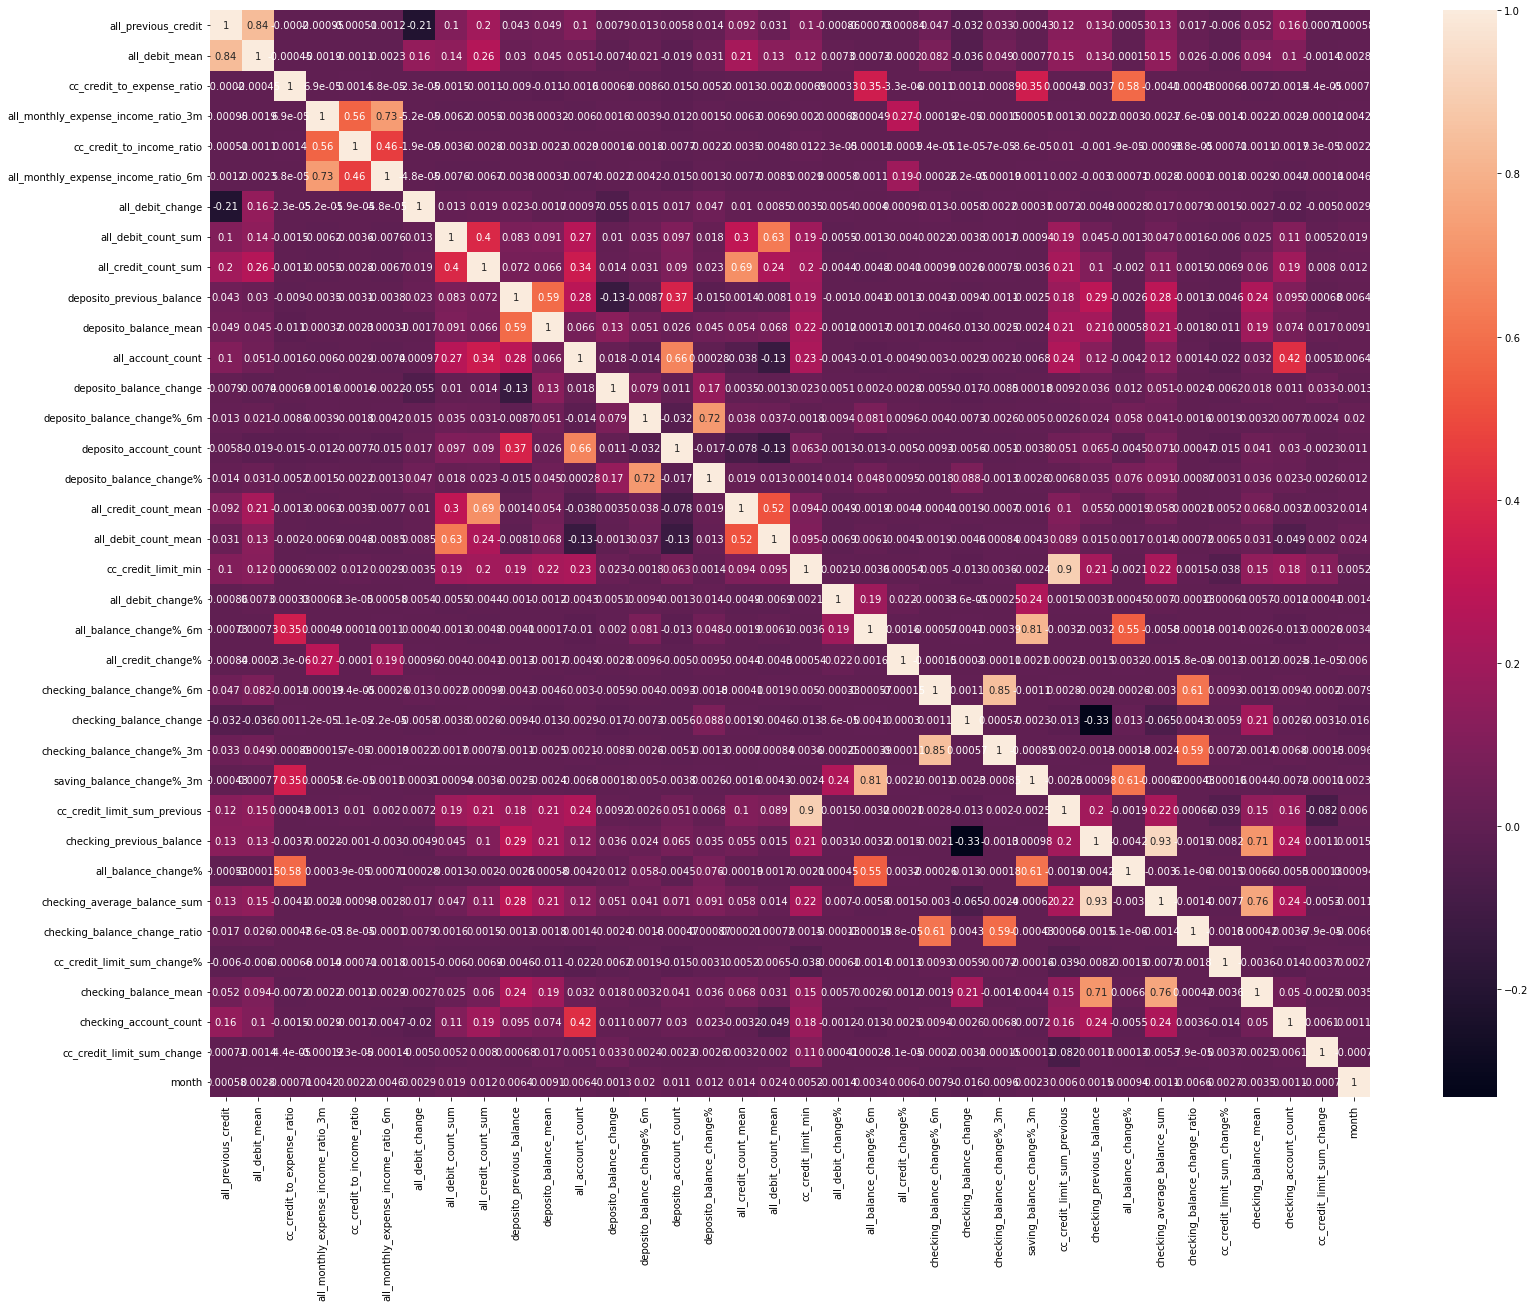

In [79]:
# final check of multicollinearity (making sure all features have <= 0.9 linear correlation between predictors) 
pd.options.display.max_rows=None
plt.figure(figsize=(26,20))
sns.heatmap(train_df[considered_features].corr(), annot=True)

In [210]:
# final woe tables
woe[woe.Variable.isin(considered_features)]

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,all_account_count,"(0.999, 2.0]",195272,1685,0.86,193587,0.65,0.28,0.06
1,all_account_count,"(2.0, 3.0]",42255,139,0.07,42116,0.14,-0.69,0.05
2,all_account_count,"(3.0, 4.0]",23967,65,0.03,23902,0.08,-0.88,0.04
3,all_account_count,"(4.0, 5.0]",13654,23,0.01,13631,0.05,-1.36,0.05
4,all_account_count,"(5.0, 235.0]",24480,44,0.02,24436,0.08,-1.29,0.08
0,all_balance_change%,"(-1.001, -0.718]",27477,306,0.16,27171,0.09,0.54,0.04
1,all_balance_change%,"(-0.718, -0.447]",27499,216,0.11,27283,0.09,0.19,0.00
2,all_balance_change%,"(-0.447, -0.237]",27363,186,0.10,27177,0.09,0.04,0.00
3,all_balance_change%,"(-0.237, -0.0902]",27426,152,0.08,27274,0.09,-0.16,0.00
4,all_balance_change%,"(-0.0902, -0.008]",27775,130,0.07,27645,0.09,-0.33,0.01


## Model Development  (Experiment0 - Best Algorithm) <a name='modelling3'></a>

In [27]:
# saved features checkpoint for experiment1
considered_features = [
        'all_previous_credit',
        'all_debit_mean',
        'cc_credit_to_expense_ratio',
        'all_monthly_expense_income_ratio_3m',
        'cc_credit_to_income_ratio',
        'all_monthly_expense_income_ratio_6m',
        'all_debit_change',
        'all_debit_count_sum',
        'all_credit_count_sum',
        'deposito_previous_balance',
        'deposito_balance_mean',
        'all_account_count',
        'deposito_balance_change',
        'deposito_balance_change%_6m',
        'deposito_account_count',
        'deposito_balance_change%',
        'all_credit_count_mean',
        'all_debit_count_mean',
        'cc_credit_limit_min',
        'all_debit_change%',
        'all_balance_change%_6m',
        'all_credit_change%',
        'checking_balance_change%_6m',
        'checking_balance_change',
        'checking_balance_change%_3m',
        'saving_balance_change%_3m',
        'cc_credit_limit_sum_previous',
        'checking_previous_balance',
        'all_balance_change%',
        'checking_average_balance_sum',
        'checking_balance_change_ratio',
        'cc_credit_limit_sum_change%',
        'checking_balance_mean',
        'checking_account_count',
        'cc_credit_limit_sum_change',
        'month'
]

In [28]:
# making the data splits more easily accessible
x_train = train_df[considered_features]
x_val = val_df[considered_features]
x_test = test_df[considered_features]

y_train = train_df['is_default']
y_val = val_df['is_default']
y_test = test_df['is_default']

### 1) Model Selection By CV Scores on Train Data

CB: 0.830938 (0.012420)
XGB: 0.828673 (0.011170)
NN: 0.521516 (0.037504)
DT: 0.524175 (0.001796)
LR: 0.664795 (0.011670)
NB: 0.647750 (0.012538)


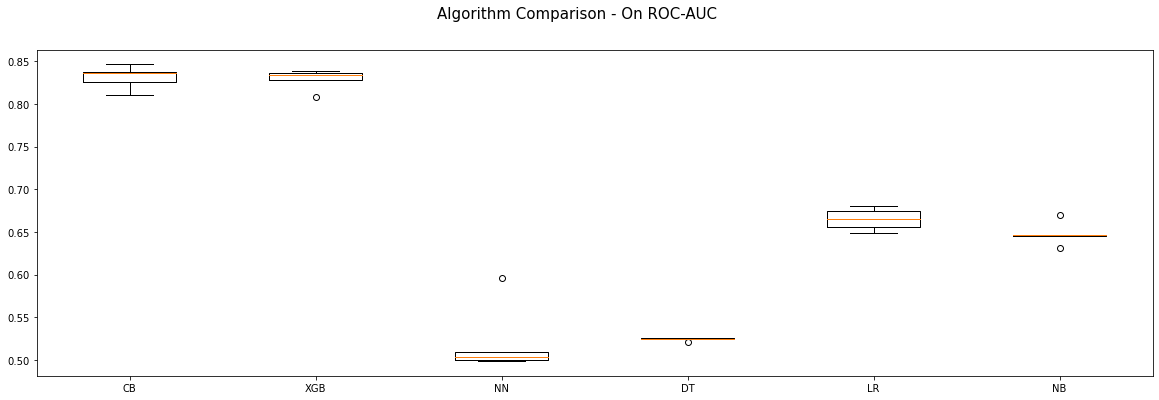

In [215]:
# evaluating again but without the domain features 
models = []
models.append(('CB', CatBoostClassifier(random_state=7, early_stopping_rounds=50, eval_metric='AUC')))
models.append(('XGB', XGBClassifier(random_state=7)))
models.append(('NN', MLPClassifier(random_state=7)))
models.append(('DT', DecisionTreeClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('NB', BernoulliNB()))
results = []
names = []

# evaluate each model in turn for normal   
for name, model in models:
    cv_results = cross_val_score(model, x_train.fillna(0), y_train, cv=5, n_jobs=-3, scoring= 'roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
            
# boxplot algorithm comparison for normal
fig = plt.figure(figsize=(20,6))
fig.suptitle('Algorithm Comparison - On ROC-AUC', fontsize=15)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### 2) Model Selection By Classification Report on Validation & Test Data

In [125]:
# model fitting (training data as is)
cb = CatBoostClassifier(
    eval_metric='AUC',
    use_best_model=True,
    od_type='IncToDec',
    od_pval=1e-2,
    verbose=0,
    early_stopping_rounds=50,
    random_state=7,
)
cb.fit(x_train, y_train, eval_set=(x_val, y_val))

### Classification Report on Validation
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76964
           1       0.00      0.00      0.00      1036

    accuracy                           0.99     78000
   macro avg       0.49      0.50      0.50     78000
weighted avg       0.97      0.99      0.98     78000



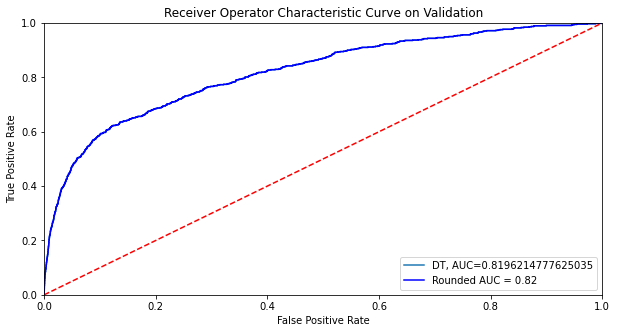

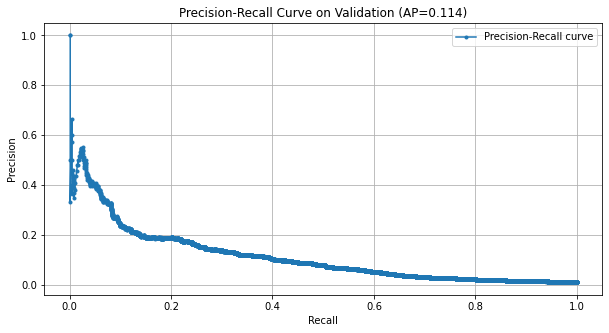

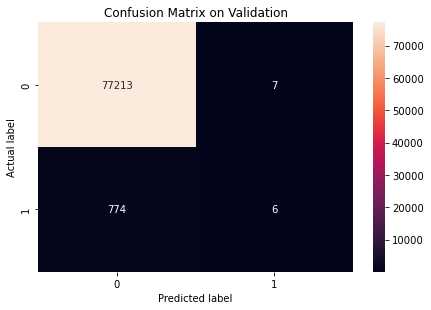

### Classification Report on Test
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76964
           1       0.43      0.01      0.02      1036

    accuracy                           0.99     78000
   macro avg       0.71      0.50      0.51     78000
weighted avg       0.98      0.99      0.98     78000



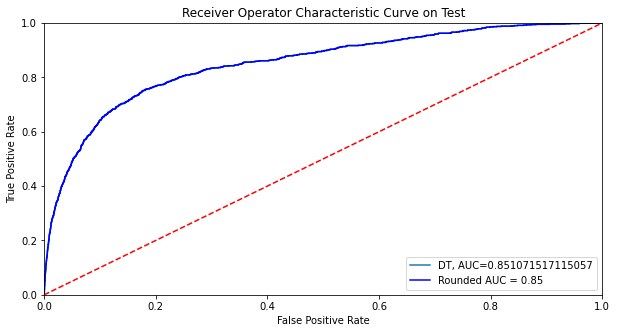

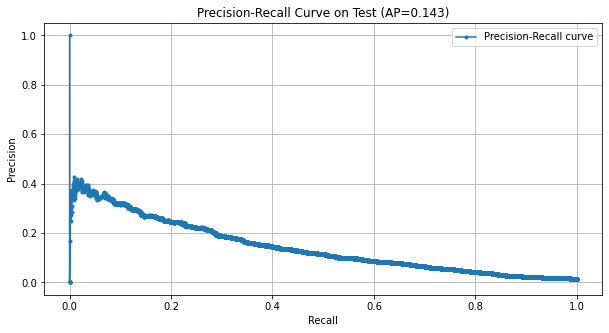

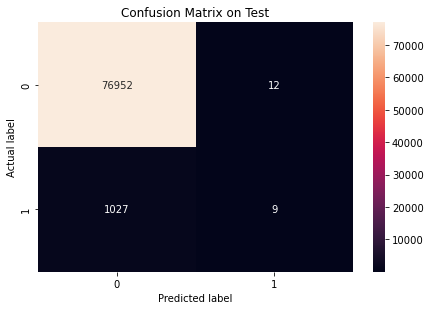

In [126]:
# classification reports 
for x_, y_, name in list(zip([x_val, x_test],[y_val, y_test], ['Validation','Test'])):
    from sklearn import metrics
    cb_pred_proba = cb.predict_proba(x_)[::,1]
    cb_pred = cb.predict(x_)
    print(f'### Classification Report on {name}')
    print(classification_report(y_test, cb_pred))

    # ROC-AUC score
    fpr, tpr, _ = metrics.roc_curve(y_, cb_pred_proba)
    auc = metrics.roc_auc_score(y_, cb_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize= (10,5))
    plt.title(f'Receiver Operator Characteristic Curve on {name}')
    plt.plot(fpr,tpr,label="DT, AUC="+str(auc))
    plt.plot(fpr, tpr, 'b', label= 'Rounded AUC = {}'.format(round(roc_auc,2)))
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    # precision-recall curve
    precision, recall, thresholds = metrics.precision_recall_curve(y_, cb_pred_proba)
    average_precision = metrics.average_precision_score(y_, cb_pred_proba)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on {name} (AP={average_precision:.3f})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # confusion matrix 
    cnf_matrix = metrics.confusion_matrix(y_, cb_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,  fmt='g')
    plt.tight_layout()
    plt.title(f'Confusion Matrix on {name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

## Model Development  (Experiment1 - Adding Class Weights) <a name='modelling4'></a>

In [29]:
# calculating the class weights hyperparameter (avoiding oversampling/undersampling to keep data as is)
from collections import Counter
counter = Counter(y_train)
negative_count = counter[0]
positive_count = counter[1]
scale_pos_weight = negative_count / positive_count
class_weights = {0: 1, 1: scale_pos_weight}

In [128]:
# model fitting 
cb1 = CatBoostClassifier(
    eval_metric='AUC',
    use_best_model=True,
    od_type='IncToDec',
    od_pval=1e-2,
    verbose=0,
    early_stopping_rounds=50,
    random_state=7,
    class_weights=class_weights
)
cb1.fit(x_train, y_train, eval_set=(x_val, y_val))

### Classification Report on Validation
              precision    recall  f1-score   support

           0       0.99      0.77      0.86     76964
           1       0.01      0.21      0.02      1036

    accuracy                           0.76     78000
   macro avg       0.50      0.49      0.44     78000
weighted avg       0.97      0.76      0.85     78000



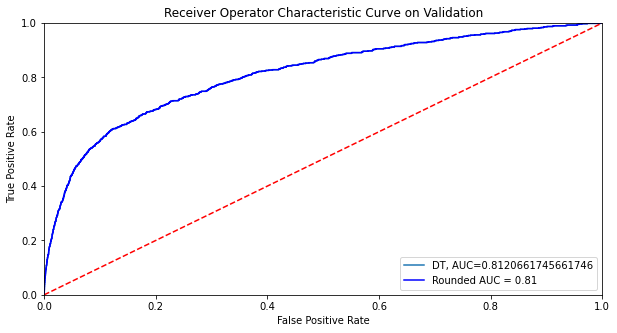

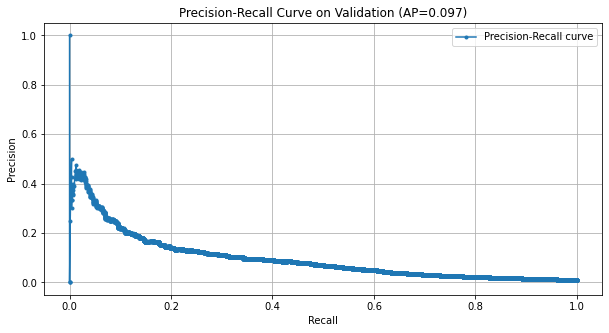

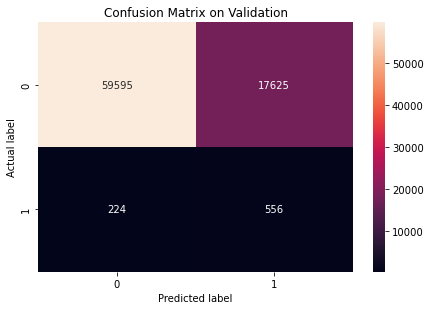

### Classification Report on Test
              precision    recall  f1-score   support

           0       1.00      0.74      0.85     76964
           1       0.04      0.78      0.07      1036

    accuracy                           0.74     78000
   macro avg       0.52      0.76      0.46     78000
weighted avg       0.98      0.74      0.84     78000



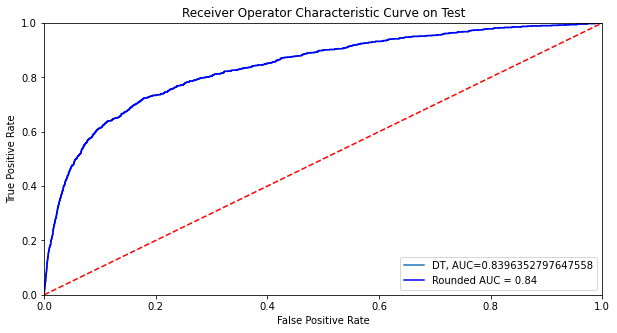

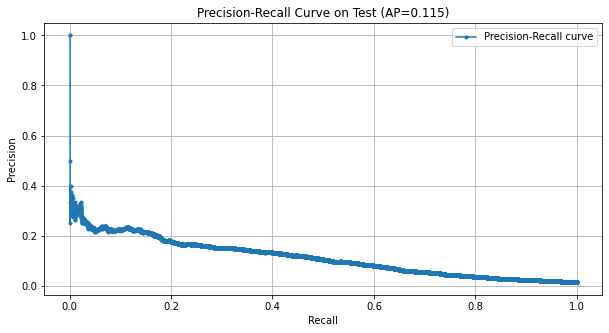

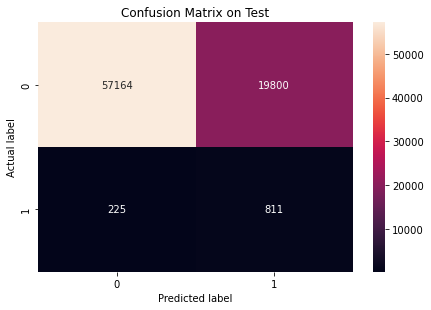

In [129]:
# classification reports 
for x_, y_, name in list(zip([x_val, x_test],[y_val, y_test], ['Validation','Test'])):
    from sklearn import metrics
    cb_pred_proba = cb1.predict_proba(x_)[::,1]
    cb_pred = cb1.predict(x_)
    print(f'### Classification Report on {name}')
    print(classification_report(y_test, cb_pred))

    # ROC-AUC score
    fpr, tpr, _ = metrics.roc_curve(y_, cb_pred_proba)
    auc = metrics.roc_auc_score(y_, cb_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize= (10,5))
    plt.title(f'Receiver Operator Characteristic Curve on {name}')
    plt.plot(fpr,tpr,label="DT, AUC="+str(auc))
    plt.plot(fpr, tpr, 'b', label= 'Rounded AUC = {}'.format(round(roc_auc,2)))
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    # precision-recall curve
    precision, recall, thresholds = metrics.precision_recall_curve(y_, cb_pred_proba)
    average_precision = metrics.average_precision_score(y_, cb_pred_proba)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on {name} (AP={average_precision:.3f})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # confusion matrix 
    cnf_matrix = metrics.confusion_matrix(y_, cb_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,  fmt='g')
    plt.tight_layout()
    plt.title(f'Confusion Matrix on {name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

## Model Development  (Experiment2 - Adding Domain Features) <a name='modelling5'></a>

In [44]:
# inserting domain knowledge features (giving information on previous months credit history)
domain_features = ['cc_delinquency_score_max_previous_mean_6m']
considered_features2 = domain_features + considered_features
considered_features2

['cc_delinquency_score_max_previous_mean_6m',
 'all_previous_credit',
 'all_debit_mean',
 'cc_credit_to_expense_ratio',
 'all_monthly_expense_income_ratio_3m',
 'cc_credit_to_income_ratio',
 'all_monthly_expense_income_ratio_6m',
 'all_debit_change',
 'all_debit_count_sum',
 'all_credit_count_sum',
 'deposito_previous_balance',
 'deposito_balance_mean',
 'all_account_count',
 'deposito_balance_change',
 'deposito_balance_change%_6m',
 'deposito_account_count',
 'deposito_balance_change%',
 'all_credit_count_mean',
 'all_debit_count_mean',
 'cc_credit_limit_min',
 'all_debit_change%',
 'all_balance_change%_6m',
 'all_credit_change%',
 'checking_balance_change%_6m',
 'checking_balance_change',
 'checking_balance_change%_3m',
 'saving_balance_change%_3m',
 'cc_credit_limit_sum_previous',
 'checking_previous_balance',
 'all_balance_change%',
 'checking_average_balance_sum',
 'checking_balance_change_ratio',
 'cc_credit_limit_sum_change%',
 'checking_balance_mean',
 'checking_account_count'

In [45]:
# making the data splits 
x_train = train_df[considered_features2]
x_val = val_df[considered_features2]
x_test = test_df[considered_features2]

y_train = train_df['is_default']
y_val = val_df['is_default']
y_test = test_df['is_default']

In [132]:
# model fitting 
cb2 = CatBoostClassifier(
    eval_metric='AUC',
    use_best_model=True,
    od_type='IncToDec',
    od_pval=1e-2,
    verbose=0,
    early_stopping_rounds=50,
    random_state=7,
    class_weights=class_weights
)
cb2.fit(x_train, y_train, eval_set=(x_val, y_val))

### Classification Report on Validation
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     76964
           1       0.01      0.03      0.02      1036

    accuracy                           0.95     78000
   macro avg       0.50      0.50      0.49     78000
weighted avg       0.97      0.95      0.96     78000



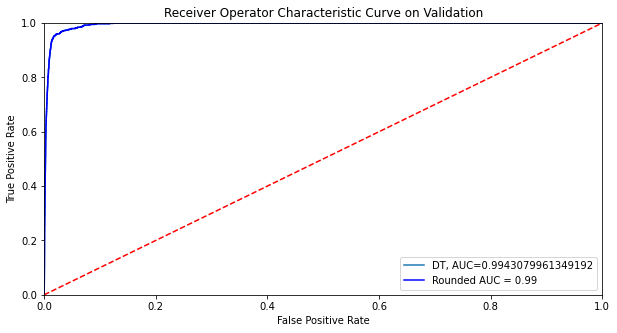

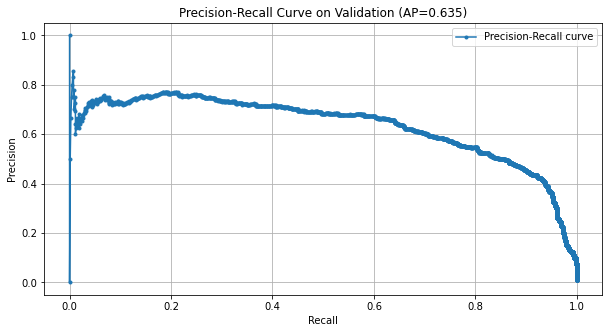

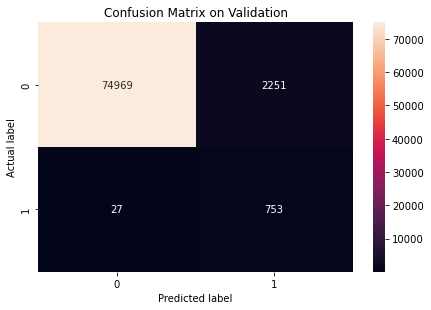

### Classification Report on Test
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     76964
           1       0.27      0.96      0.43      1036

    accuracy                           0.97     78000
   macro avg       0.64      0.96      0.70     78000
weighted avg       0.99      0.97      0.97     78000



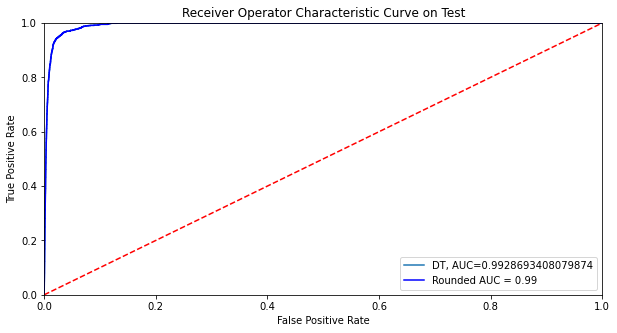

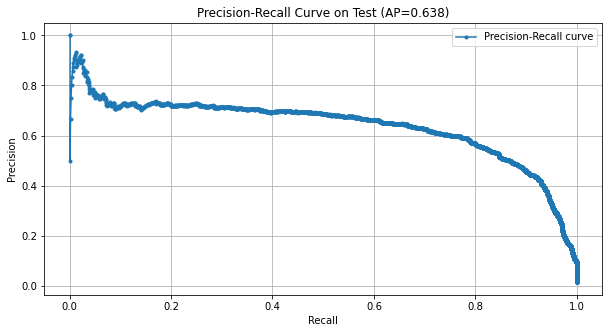

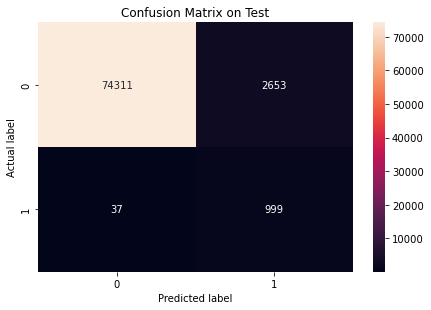

In [133]:
# classification reports 
for x_, y_, name in list(zip([x_val, x_test],[y_val, y_test], ['Validation','Test'])):
    from sklearn import metrics
    cb_pred_proba = cb2.predict_proba(x_)[::,1]
    cb_pred = cb2.predict(x_)
    print(f'### Classification Report on {name}')
    print(classification_report(y_test, cb_pred))

    # ROC-AUC score
    fpr, tpr, _ = metrics.roc_curve(y_, cb_pred_proba)
    auc = metrics.roc_auc_score(y_, cb_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize= (10,5))
    plt.title(f'Receiver Operator Characteristic Curve on {name}')
    plt.plot(fpr,tpr,label="DT, AUC="+str(auc))
    plt.plot(fpr, tpr, 'b', label= 'Rounded AUC = {}'.format(round(roc_auc,2)))
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    # precision-recall curve
    precision, recall, thresholds = metrics.precision_recall_curve(y_, cb_pred_proba)
    average_precision = metrics.average_precision_score(y_, cb_pred_proba)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on {name} (AP={average_precision:.3f})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # confusion matrix 
    cnf_matrix = metrics.confusion_matrix(y_, cb_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,  fmt='g')
    plt.tight_layout()
    plt.title(f'Confusion Matrix on {name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

## Model Development  (Experiment3 - Using WOE Binning) <a name='modelling6'></a>

In [28]:
# binning based on training data
bins = sc.woebin(train_df[considered_features2 + ['is_default']], y='is_default')

[INFO] creating woe binning ...
Binning on 299628 rows and 38 columns in 00:03:02


In [30]:
# woe binning
x_train_woe = sc.woebin_ply(x_train, bins)
x_val_woe = sc.woebin_ply(x_val, bins)
x_test_woe = sc.woebin_ply(x_test, bins)

[INFO] converting into woe values ...
Woe transformating on 299628 rows and 37 columns in 00:02:29
[INFO] converting into woe values ...
Woe transformating on 78000 rows and 37 columns in 00:00:39
[INFO] converting into woe values ...
Woe transformating on 78000 rows and 37 columns in 00:00:39


In [46]:
# model fitting 
cb3 = CatBoostClassifier(
    eval_metric='AUC',
    use_best_model=True,
    od_type='IncToDec',
    od_pval=1e-2,
    verbose=0,
    early_stopping_rounds=50,
    random_state=7,
    class_weights=class_weights
)
cb3.fit(x_train_woe, y_train, eval_set=(x_val_woe, y_val))

### Classification Report on Validation
              precision    recall  f1-score   support

           0       0.99      0.72      0.83     76964
           1       0.01      0.26      0.02      1036

    accuracy                           0.71     78000
   macro avg       0.50      0.49      0.43     78000
weighted avg       0.97      0.71      0.82     78000



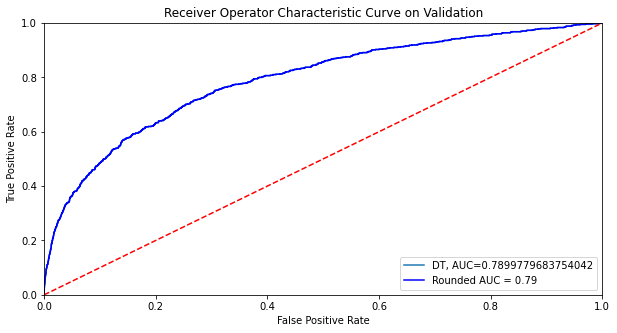

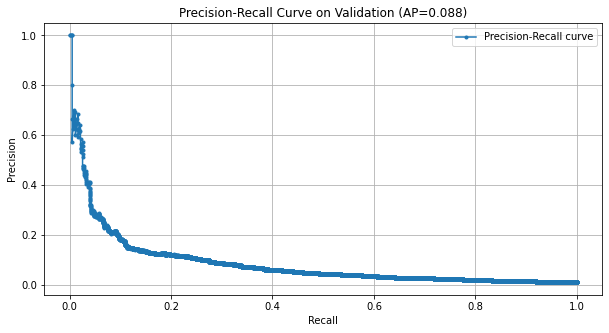

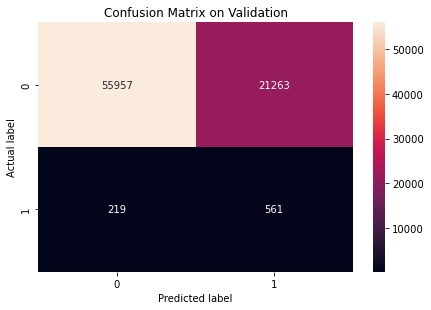

### Classification Report on Test
              precision    recall  f1-score   support

           0       1.00      0.69      0.81     76964
           1       0.03      0.76      0.06      1036

    accuracy                           0.69     78000
   macro avg       0.51      0.72      0.44     78000
weighted avg       0.98      0.69      0.80     78000



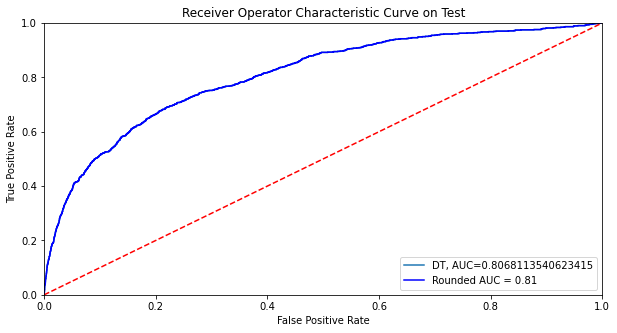

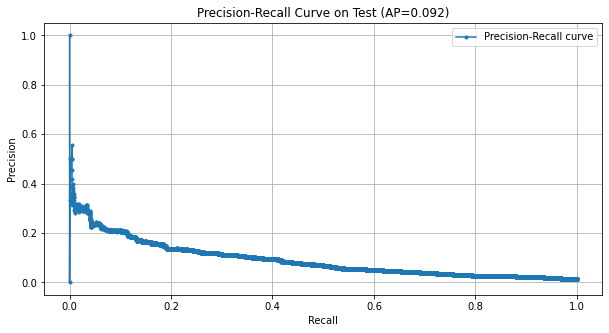

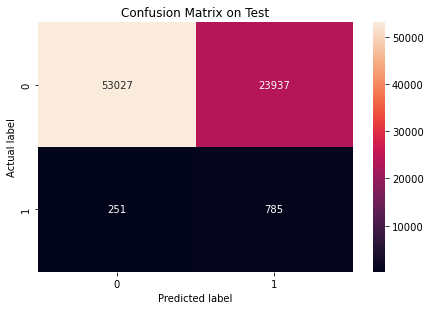

In [48]:
# classification reports 
for x_, y_, name in list(zip([x_val_woe, x_test_woe],[y_val, y_test], ['Validation','Test'])):
    from sklearn import metrics
    cb_pred_proba = cb3.predict_proba(x_)[::,1]
    cb_pred = cb3.predict(x_)
    print(f'### Classification Report on {name}')
    print(metrics.classification_report(y_test, cb_pred))

    # ROC-AUC score
    fpr, tpr, _ = metrics.roc_curve(y_, cb_pred_proba)
    auc = metrics.roc_auc_score(y_, cb_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize= (10,5))
    plt.title(f'Receiver Operator Characteristic Curve on {name}')
    plt.plot(fpr,tpr,label="DT, AUC="+str(auc))
    plt.plot(fpr, tpr, 'b', label= 'Rounded AUC = {}'.format(round(roc_auc,2)))
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    # precision-recall curve
    precision, recall, thresholds = metrics.precision_recall_curve(y_, cb_pred_proba)
    average_precision = metrics.average_precision_score(y_, cb_pred_proba)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on {name} (AP={average_precision:.3f})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # confusion matrix 
    cnf_matrix = metrics.confusion_matrix(y_, cb_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,  fmt='g')
    plt.tight_layout()
    plt.title(f'Confusion Matrix on {name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

## Model Development  (Experiment4 - Optuna Hyperparameter Tuning) <a name='modelling7'></a>

In [51]:
# current scale_pos_weight
scale_pos_weight

152.1840490797546

In [53]:
# current class weight
class_weights

{0: 1, 1: 152.1840490797546}

In [35]:
# the optuna objective function for hyperparameter tuning (objective on validation)
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 10, 152.1840490797546),
        'eval_metric': 'AUC',
        'use_best_model': True
    }
    
    model = CatBoostClassifier(**param, verbose=0, random_seed=7)
    model.fit(x_train, y_train, eval_set=(x_val, y_val), early_stopping_rounds=50)
    y_score = model.predict_proba(x_val)[:, 1]
    auc = metrics.roc_auc_score(y_val, y_score)
    ap = metrics.average_precision_score(y_val, y_score)
    final = (0.6*auc) + (0.4*ap)
    
    return final

# create and run the optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [36]:
# capturing the best parameters
print("""[I 2024-06-08 16:22:37,890] 
    Trial 32 finished with value: 0.8852098936876487 and parameters: 
    {'iterations': 737, 'depth': 10, 'learning_rate': 0.01644521923534368, 
    'l2_leaf_reg': 0.6746239121434441, 'bagging_temperature': 0.6313479734924503, 
    'border_count': 97, 'scale_pos_weight': 11.257996367697306}. 
    Best is trial 32 with value: 0.8852098936876487""")

[I 2024-06-08 16:22:37,890] 
    Trial 32 finished with value: 0.8852098936876487 and parameters: 
    {'iterations': 737, 'depth': 10, 'learning_rate': 0.01644521923534368, 
    'l2_leaf_reg': 0.6746239121434441, 'bagging_temperature': 0.6313479734924503, 
    'border_count': 97, 'scale_pos_weight': 11.257996367697306}. 
    Best is trial 32 with value: 0.8852098936876487


In [46]:
# saving the best params in 50 trials
best_params = {'iterations': 737, 
                 'depth': 10, 
                 'learning_rate': 0.01644521923534368, 
                 'l2_leaf_reg': 0.6746239121434441, 
                 'bagging_temperature': 0.6313479734924503, 
                 'border_count': 97, 
                 'scale_pos_weight': 11.257996367697306}

In [48]:
%%time
# model fitting 
tuned_cb = CatBoostClassifier(**best_params, verbose=0, random_seed=7)
tuned_cb.fit(x_train, y_train, eval_set=(x_val, y_val), early_stopping_rounds=50)

CPU times: total: 2min 51s
Wall time: 1min 3s


### Classification Report on Validation
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     76964
           1       0.01      0.01      0.01      1036

    accuracy                           0.97     78000
   macro avg       0.50      0.50      0.50     78000
weighted avg       0.97      0.97      0.97     78000



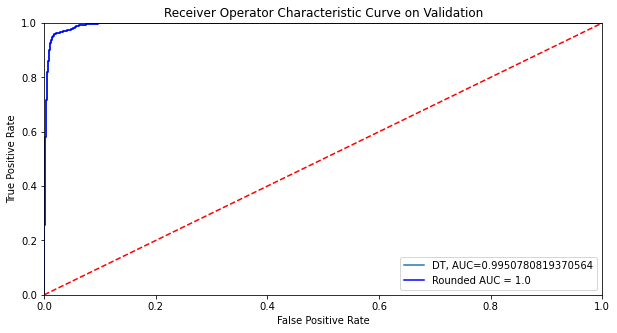

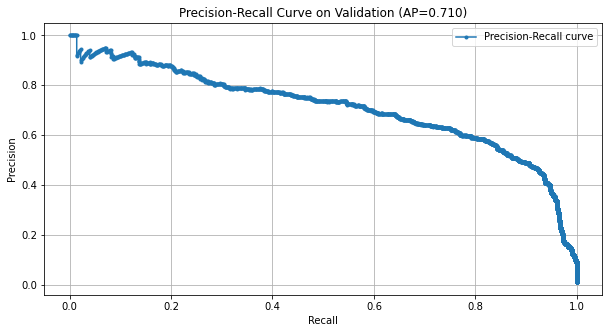

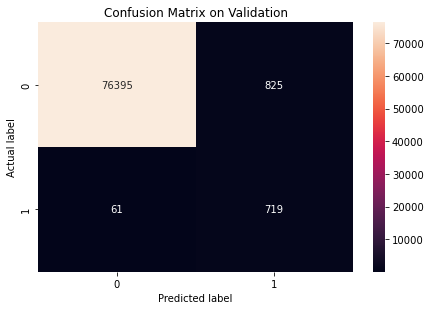

### Classification Report on Test
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     76964
           1       0.47      0.91      0.62      1036

    accuracy                           0.99     78000
   macro avg       0.73      0.95      0.81     78000
weighted avg       0.99      0.99      0.99     78000



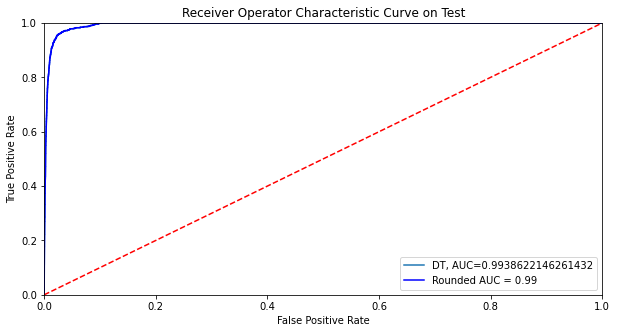

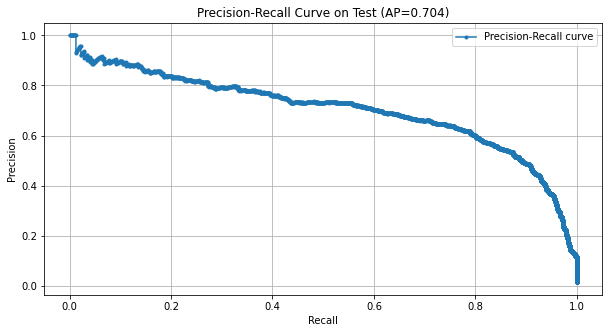

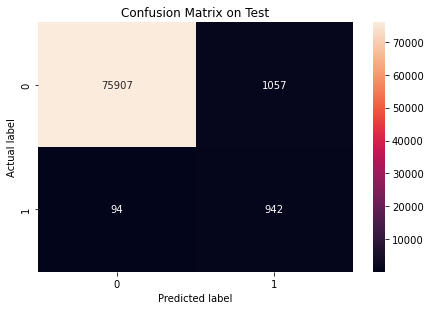

In [49]:
# classification reports 
for x_, y_, name in list(zip([x_val, x_test],[y_val, y_test], ['Validation','Test'])):
    from sklearn import metrics
    cb_pred_proba = tuned_cb.predict_proba(x_)[::,1]
    cb_pred = tuned_cb.predict(x_)
    print(f'### Classification Report on {name}')
    print(metrics.classification_report(y_test, cb_pred))

    # ROC-AUC score
    fpr, tpr, _ = metrics.roc_curve(y_, cb_pred_proba)
    auc = metrics.roc_auc_score(y_, cb_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize= (10,5))
    plt.title(f'Receiver Operator Characteristic Curve on {name}')
    plt.plot(fpr,tpr,label="DT, AUC="+str(auc))
    plt.plot(fpr, tpr, 'b', label= 'Rounded AUC = {}'.format(round(roc_auc,2)))
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    # precision-recall curve
    precision, recall, thresholds = metrics.precision_recall_curve(y_, cb_pred_proba)
    average_precision = metrics.average_precision_score(y_, cb_pred_proba)
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve on {name} (AP={average_precision:.3f})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # confusion matrix 
    cnf_matrix = metrics.confusion_matrix(y_, cb_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,  fmt='g')
    plt.tight_layout()
    plt.title(f'Confusion Matrix on {name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

## Model Explainability & Probability of Default (PD)<a name='modelling8'><a/>

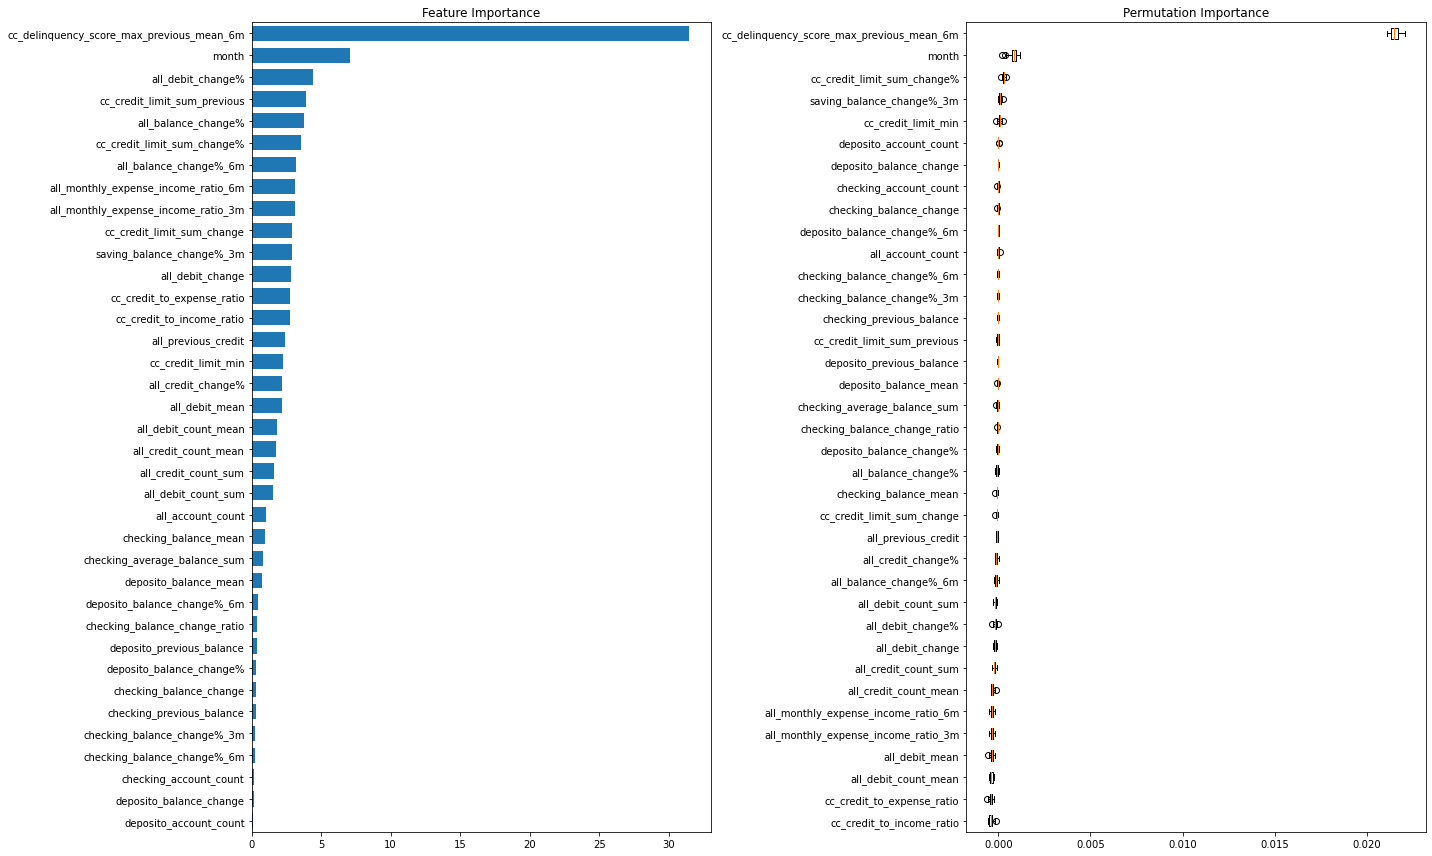

In [69]:
# showing feature importance & permutation importance side by side on test data
model_ = tuned_cb
data_ = x_test
target_ = y_test

r = permutation_importance(model_, x_test, y_test,
                           n_repeats=30,
                           random_state=0)
perm_sorted_idx = r.importances_mean.argsort()
ctb_importance_sorted_idx = np.argsort(model_.feature_importances_)
ctb_indices = np.arange(0, len(model_.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
ax1.barh(ctb_indices, model_.feature_importances_[ctb_importance_sorted_idx], height=0.7)
ax1.set_title('Feature Importance')
ax1.set_yticks(ctb_indices)
ax1.set_yticklabels(data_.columns[ctb_importance_sorted_idx])
ax1.set_ylim((0, len(model_.feature_importances_)))
ax2.set_title('Permutation Importance')
ax2.boxplot(
    r.importances[perm_sorted_idx].T,
    vert=False,
    labels=data_.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

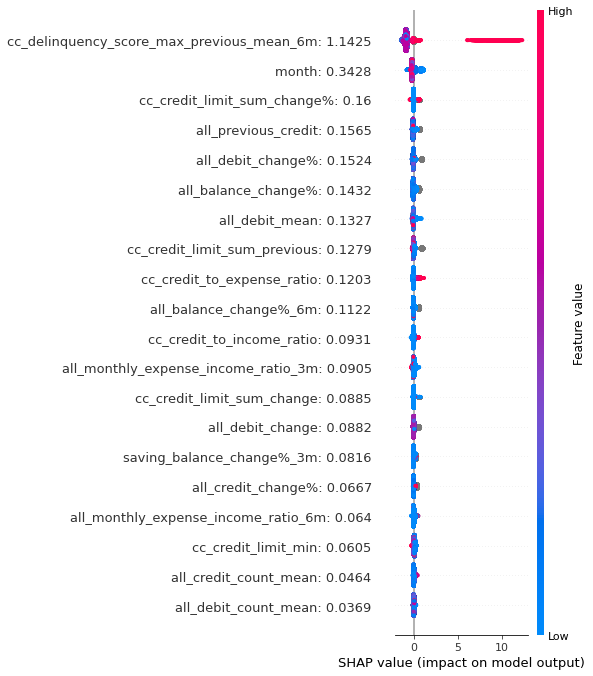

In [70]:
# on test data, with shap feature weights
explainer = shap.TreeExplainer(model_)
shap_values = explainer.shap_values(data_)

feature_names = [
    a + ": " + str(b) for a, b in zip(data_.columns, np.abs(shap_values).mean(0).round(4))
]

shap.summary_plot(shap_values,
                  data_,
                  feature_names=feature_names)

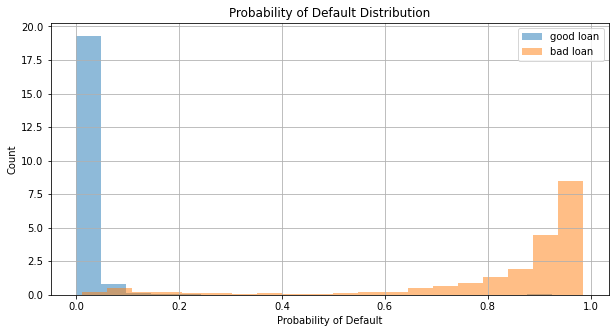

In [82]:
# final probability of default (PD)
modelling_df['PD'] = tuned_cb.predict_proba(modelling_df[considered_features2])[::,1]  

# showing proability of default distribution
plt.figure(figsize=(10,5))
plt.title('Probability of Default Distribution')
modelling_df[modelling_df['is_default']==0]['PD'].hist(bins = 20, alpha = 0.5, label = 'good loan', density = True)
modelling_df[modelling_df['is_default']==1]['PD'].hist(bins = 20, alpha = 0.5, label = 'bad loan', density = True)
plt.xlabel('Probability of Default')
plt.ylabel('Count')
plt.legend(loc=1)
plt.show()

### Things to highlight:
- After the data has been split accordingly (maintaining the 1:0 class distribution relatively the same across samples), I conduct several analysis. From PSI analysis to make sure the features used are stable, IV analysis to see which features are good predictors & VIF to know which features are essentially redundant & high in multicollinearity. The end features are around 36 features.
- From multiple algorithms, we see that CatBoost is performing the best in terms of AUC. Therefore, the following optimization process is done with that model architecture.
- There has been some uplifts in test data performance when simple CatBoost is added class weights (to approximate the higly imbalanced data), domain feature (avg credit history from the previous months) & hyperparameter tuning (with objective of validation data in term of AUC-AP). However, using WOE Binnings seems to make the CatBoost model to perform worse.
- The final model used is the tuned CatBoost with optimized weights & hyperparameters that achieved Average Precision of 0.7 with overall AUC of 0.99. This model's most powerful feature is the cc_delinquency_score_max_previous_mean_6m (credit history feature) that gets from the previous 6 months, the average of its maximum credit delinquency scores. The interpretation is also logical, that if users' previous loans history is teeming with higher delinquency score, it is more likely that the current month has higher delinquency score as well.